# **Metapath2Vec and Doc2Vec Embedding Analyses**
#### This notebook analyzes metapath2vec and Doc2Vec embedding models
#### *The notebook is divided into the following sections:*
* **Dependencies**
* **metapath2vec embeddings**
* **metapath2vec++ embeddings**
* **ML evaluations 1: graph embeddings**
    * Import processed text data
    * Create train/test sets
    * Prediction
* **ML evaluations 2: graph + doc embeddings**
    * Load Doc2Veec models
    * Get author embeddings
    * Create train/test sets
    * Prediction
        * *All D2V data*
        * *D2V means*
        * *D2V means and SDs*
    * Prediction: full SW sample
        * *Predict on full SW sample*
        * *Prediction visualizations*
* **Doc2Vec analyses**
    * DBOW model evaluations
    * DM model evaluations
* **Correlation evaluations between graph and doc embeddings**
    * Pearson correlation matrix
    * Plot correlations and regression lines
* metapath2vec 3D visualizations
    * Static 3D visualizations
    * Rotating 3D animation

# Import dependencies

In [1]:
# Import general dependencies
import os
from pathlib import Path
import gc
import numpy as np
import pandas as pd
import itertools
from operator import itemgetter
import random
import pickle

# Import viz dependencies
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

# Import graph dependencies
from graph_tool.all import *
import graph_tool.all as gt
import gensim
import umap

# Import ML dependencies
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Print timestamp of last runtime:
from time import time
from datetime import datetime
from pprint import pprint
print("Last runtime:", datetime.now())

Last runtime: 2019-05-11 20:06:23.206497


In [2]:
# Set datasource path
datasource = '/media/seagate0/reddit/'

# Setup metapath2vec path
mpsource = "/media/seagate0/reddit/samples/metapath2vec/medium/"

# Load graph

In [3]:
# Load graph object
graph_med = datasource+"graphs/gs_SW_MultiRel_gt_med.gt" # edit if necessary
graph = gt.load_graph(graph_med)

In [4]:
print("Graph nodes: {}; edges: {}".format(graph.num_vertices(), graph.num_edges()))
graph.list_properties()

Graph nodes: 9917270; edges: 45299669
MH_subreddits  (vertex)  (type: bool)
SH_subreddits  (vertex)  (type: bool)
SWMHSH_name    (vertex)  (type: string)
auth           (vertex)  (type: bool)
authComm       (vertex)  (type: bool)
authSubm       (vertex)  (type: bool)
cTime          (vertex)  (type: int32_t)
comm           (vertex)  (type: bool)
id             (vertex)  (type: string)
labeled_auth   (vertex)  (type: bool)
labeled_dx     (vertex)  (type: string)
labeled_si     (vertex)  (type: string)
labeled_subm   (vertex)  (type: bool)
sTime          (vertex)  (type: int32_t)
sampMH         (vertex)  (type: bool)
sampR          (vertex)  (type: bool)
sampSH         (vertex)  (type: bool)
sampSW         (vertex)  (type: bool)
subm           (vertex)  (type: bool)
subr           (vertex)  (type: bool)
type           (vertex)  (type: string)
type_name      (vertex)  (type: string)
viewAuthSubr   (vertex)  (type: bool)
lTime          (edge)    (type: int32_t)
pathAuthAuth   (edge)    (typ

In [5]:
# Set supplemental paths (labeled auths/subms and subr seeds for MH and SH samples)
labeled_data  = "/media/seagate0/reddit/origin/psych/psytrain_labeled_auth_id_si_dx.csv"
labeled_data  = pd.read_csv(labeled_data)
MH_subreddits = "/media/seagate0/reddit/samples/subreddits_mentalhealth.txt"
MH_subreddits = pd.read_csv(MH_subreddits, header=None).values.tolist()
MH_subreddits = [subr[0] for subr in MH_subreddits]
SH_subreddits = "/media/seagate0/reddit/samples/subreddits_selfhelp.txt"
SH_subreddits = pd.read_csv(SH_subreddits, header=None).values.tolist()
SH_subreddits = [subr[0] for subr in SH_subreddits]

In [6]:
# Import node ids and rows to keep
id_author = pickle.load(open(mpsource+"id_author.pkl", "rb"))
author_id = pickle.load(open(mpsource+"author_id.pkl", "rb"))
id_conf   = pickle.load(open(mpsource+"id_conf.pkl",   "rb"))
conf_id   = pickle.load(open(mpsource+"conf_id.pkl",   "rb"))
id_paper  = pickle.load(open(mpsource+"id_paper.pkl",  "rb"))
paper_id  = pickle.load(open(mpsource+"paper_id.pkl",  "rb"))
keep_row  = pickle.load(open(mpsource+"keep_row.pkl",  "rb"))

In [ ]:
# Combine id dictionaries
ids_names = {**id_author, **id_paper}
ids_names = {**ids_names, **id_conf}
ids_names = {int(k):v for (k,v) in ids_names.items()}
names_ids = {v:k for (k,v) in ids_names.items()}
print("len ids_names:", len(list(ids_names.keys())))
print(list(ids_names.items())[:10])
print("len names_ids:", len(list(names_ids.keys())))
print(list(names_ids.items())[:10])

# metapath2vec embeddings
##### Note: trained with default mp2v settings + -size 128 -window 7 -negative 5 -threads 32 -iter 15

In [8]:
# Load embeddings
model_mp2v = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format(
    mpsource+"output.medium.cac.w1000.l100.mp2v", binary=True)
model_mp2v.vectors.shape

(1831614, 128)

In [9]:
# Retrieve node embeddings and corresponding subjects
node_ids_mp2v = model_mp2v.index2word  # list of node IDs
print("node_ids_mp2v len:", len(node_ids_mp2v))
node_embeddings_mp2v = model_mp2v.vectors  # np.ndarray of size nodes*embedding dim
print("node_embeddings_mp2v shape", node_embeddings_mp2v.shape)

node_ids_mp2v len: 1831614
node_embeddings_mp2v shape (1831614, 128)


In [10]:
node_ids_mp2v[1]

'v_AskReddit'

In [11]:
node_embeddings_mp2v[1]

array([-0.11802265, -0.0356514 ,  0.16849089, -0.14825468,  0.10371587,
       -0.06451112,  0.05638872, -0.15546803,  0.03559907, -0.00401153,
       -0.01244912, -0.05196267,  0.07730264,  0.18856224, -0.11809094,
        0.08570266,  0.05019764,  0.04295436,  0.11778283, -0.17107698,
       -0.06274508, -0.02550889,  0.09733826, -0.02179725,  0.10146426,
       -0.01139678, -0.10874198, -0.09165798, -0.02469375,  0.22781612,
        0.09350532,  0.08001319, -0.01484723,  0.13464455, -0.23375922,
        0.00221479,  0.01133917, -0.01678681, -0.09404206,  0.12399829,
       -0.07806607,  0.03513995,  0.05569178, -0.09599572, -0.0957342 ,
        0.00899549,  0.1891402 , -0.10437366,  0.07986047,  0.00871142,
        0.05321571,  0.02233051, -0.20958635, -0.06299002,  0.08354551,
        0.19046073,  0.05490879, -0.07737885, -0.22640678,  0.00998817,
        0.11506458,  0.00506082,  0.13111629, -0.06186792, -0.00073934,
       -0.07240457, -0.04333776,  0.10543312, -0.09319197, -0.00

In [12]:
%%time
# Run UMAP transformation (runtime ~2.25hrs)
print("Start time:", datetime.now())
time_start = time()
embeddings_2d_mp2v = umap.UMAP(n_components=2,
                               n_neighbors=50,
                               min_dist=0.1,
                               metric='cosine',
                               angular_rp_forest=True,
                               random_state=407,
                               verbose=True).fit_transform(node_embeddings_mp2v)
print("embeddings_2d_mp2v shape:", embeddings_2d_mp2v.shape)
print("End time:", datetime.now(), "\n")

Start time: 2019-05-07 17:43:03.153605
UMAP(a=None, angular_rp_forest=True, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='cosine',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=50, negative_sample_rate=5, random_state=407,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  21
	 1  /  21
	 2  /  21
	 3  /  21
	 4  /  21
	 5  /  21
	 6  /  21
	 7  /  21
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
embeddings_2d_mp2v shape: (1831614, 2)
En

In [45]:
%%time
# Plot the transformed embeddings
node_colours_mp2v = []
node_markers_mp2v = []
node_names_mp2v   = []
node_targets_mp2v = []
node_x_embeddings_mp2v = []
node_y_embeddings_mp2v = []

# Color and annotate node by type and community
for i in range(len(node_ids_mp2v)):
    # Skip first entity (</s> token) in node_ids_mp2v
    if i == 0:
        continue
    # Convert appended name (eg, v_* ) to real name and get UMAP pos
    node_id   = names_ids[node_ids_mp2v[i]]
    node_name = node_ids_mp2v[i][2:]
    node_targets_mp2v.append(graph.vp.type[node_id])
    node_x_embeddings_mp2v.append(embeddings_2d_mp2v[:,0][i])
    node_y_embeddings_mp2v.append(embeddings_2d_mp2v[:,1][i])
    if graph.vp.type[node_id] == "subreddit":
        if graph.vp.MH_subreddits[node_id] == True:
            if node_name == "SuicideWatch":
                node_markers_mp2v.append("P")
                node_colours_mp2v.append([255/255,0.,0.,1])
                node_names_mp2v.append(node_name)
            else:
                node_markers_mp2v.append("^")
                node_colours_mp2v.append([0.,0.,255/255,.5])
                if random.random() < 1.1:
                    node_names_mp2v.append(node_name)
                else:
                    node_names_mp2v.append('')
        elif graph.vp.SH_subreddits[node_id] == True:
            node_markers_mp2v.append("^")
            node_colours_mp2v.append([100/255,0.,255/255,.4])
            node_names_mp2v.append(node_name)
        else: #random subreddits
            node_markers_mp2v.append("^")
            node_colours_mp2v.append([0.,255/255,0.,.3])
            if random.random() < 0.01:
                node_names_mp2v.append(node_name)
            else:
                node_names_mp2v.append('')
    elif graph.vp.type[node_id] == "author":
        node_markers_mp2v.append(".")
        node_colours_mp2v.append([255/255,155/255,0.,.035])
        node_names_mp2v.append('')
    else: #submissions/comments (should be excluded from cac sample)
        raise ValueError("Unexpected value at node_ids_mp2v index", i)
for i in list(zip(node_targets_mp2v[:20], node_colours_mp2v[:20])): print (i)

('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('author', [1.0, 0.6078431372549019, 0.0, 0.035])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('author', [1.0, 0.6078431372549019, 0.0, 0.035])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('author', [1.0, 0.6078431372549019, 0.0, 0.035])
('author', [1.0, 0.6078431372549019, 0.0, 0.035])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
CPU times: user 5min 24s, sys: 759 ms, total: 5min 25s
Wall time: 5min 25s


In [120]:
len(node_names_mp2v)

1831613

In [121]:
len(node_x_embeddings_mp2v)

1831613

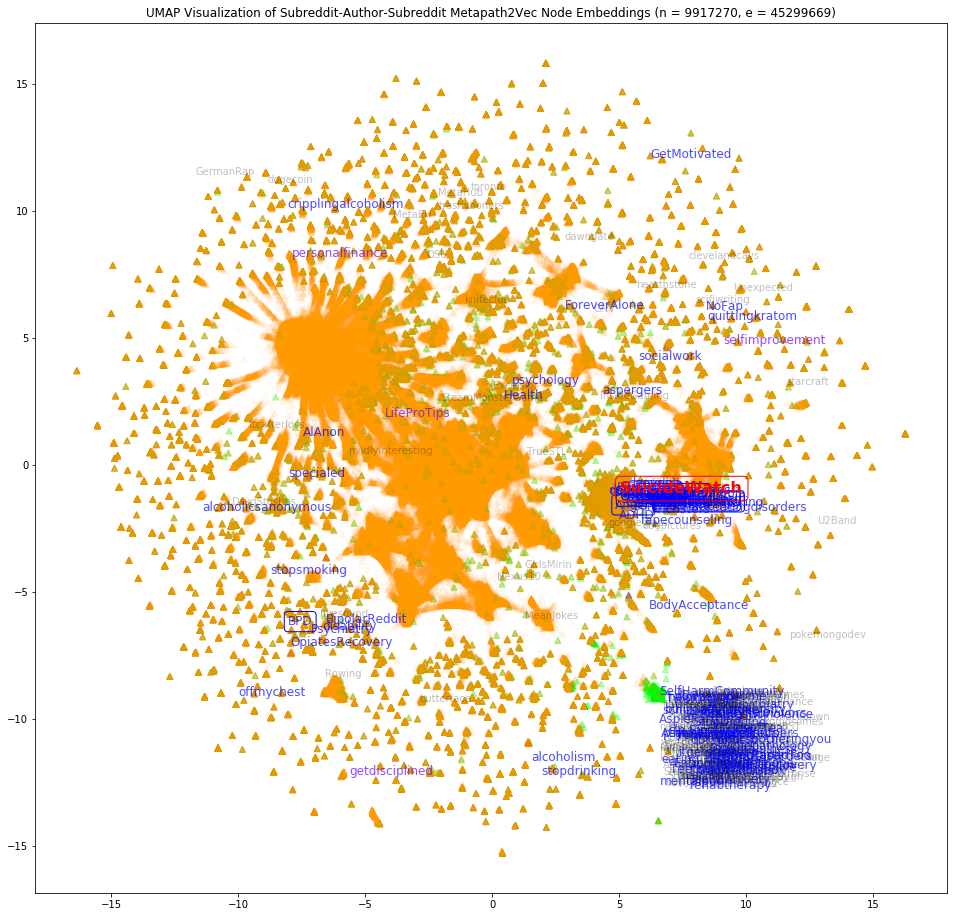

CPU times: user 12min 2s, sys: 7.29 s, total: 12min 10s
Wall time: 12min 5s


In [47]:
%%time
# Visualize the projected embeddings
plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_x_embeddings_mp2v, 
            node_y_embeddings_mp2v, 
            c=node_colours_mp2v,
            marker="^")

# Annotate the visualization
plt.title('UMAP Visualization of Subreddit-Author-Subreddit Metapath2Vec Node Embeddings (n = {}, e = {})'.format(
    graph.num_vertices(),
    graph.num_edges()))
for i,txt in enumerate(node_names_mp2v):
    if txt in MH_subreddits:
        if txt == "SuicideWatch":
            plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.0,size=1)[0]),
                     node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.0,size=1)[0]),
                     txt,
                     fontweight='bold',
                     fontsize=16,
                     color=[255/255,0.,0.,1],
                     zorder=5,
                     bbox=dict(facecolor='none', edgecolor='red', boxstyle='round'))
        elif txt == "depression":
            plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=4,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "Anxiety":
            plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=4,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "mentalhealth":
            plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=4,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "OCD":
            plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=4,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "ptsd":
            plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=4,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "BPD":
            plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=4,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "schizophrenia":
            plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=4,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "Anger":
            plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=4,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "addiction":
            plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=4,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        else:
            plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=3)
    elif txt in SH_subreddits:
        plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                 node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                 txt,
                 fontsize=12,
                 color=[100/255,0.,255/255,.7],
                 alpha=.7,
                 zorder=2)
    else:
        plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                 node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                 txt,
                 fontsize=10,
                 alpha=.25,
                 zorder=1)
        
plt.savefig('Figures/MultiRel_metapath2vec_orig_UMAP_cac_{}.png'.format(datetime.today().strftime('%Y_%m_%d')))
plt.show()

In [48]:
plt.close()

In [26]:
# Find SW's nearest neighbors
sim_sw_mp2v = []
for subr in MH_subreddits:
    try:
        subr_type_name = "v_"+subr
        sim_sw_mp2v.append([subr,model_mp2v.similarity("v_SuicideWatch", subr_type_name)])
    except:
        pass
for subr in SH_subreddits:
    try:
        subr_type_name = "v_"+subr
        sim_sw_mp2v.append([subr,model_mp2v.similarity("v_SuicideWatch", subr_type_name)])
    except:
        pass
sim_sw_mp2v = sorted(sim_sw_mp2v, key=itemgetter(1), reverse=True)
print("Similarity between SuicideWatch and ...")
for s in sim_sw_mp2v:
    print("  {}: {}".format(s[0],s[1]))

Similarity between SuicideWatch and ...
  SuicideWatch: 1.0
  depression: 0.8349847793579102
  Anxiety: 0.8210369348526001
  mentalhealth: 0.7537977695465088
  AskDocs: 0.7452985048294067
  MMFB: 0.7448685765266418
  Advice: 0.7396701574325562
  socialanxiety: 0.7318907976150513
  selfharm: 0.7312890291213989
  Needafriend: 0.7211899161338806
  StopSelfHarm: 0.7095988988876343
  OCD: 0.6441274285316467
  socialskills: 0.6363918781280518
  sad: 0.6362378001213074
  needadvice: 0.6360322833061218
  BPD: 0.6149243116378784
  survivorsofabuse: 0.6101888418197632
  selfimprovement: 0.6035711169242859
  schizophrenia: 0.592775821685791
  leaves: 0.5851913094520569
  leaves: 0.5851913094520569
  psychotherapy: 0.583105206489563
  ADHD: 0.5827494859695435
  ptsd: 0.5793533325195312
  getting_over_it: 0.5745011568069458
  aspergers: 0.5706645250320435
  selfhelp: 0.5693036317825317
  ForeverAlone: 0.5610134601593018
  Agoraphobia: 0.5598886609077454
  GFD: 0.5544381141662598
  offmychest: 0.551

# metapath2vec++ embeddings
##### Note: trained with default mp2v settings + -size 128 -window 7 -negative 5 -threads 32 -iter 15

In [30]:
# Load embeddings
model_mp2vpp = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format(
    mpsource+"output.medium.cac.w1000.l100.mp2vpp", binary=True)

In [31]:
model_mp2vpp.vectors.shape  # 128-dimensional vector for each node in the graph

(1831614, 128)

In [32]:
# Retrieve node embeddings and corresponding subjects
node_ids_mp2vpp = model_mp2vpp.index2word  # list of node IDs
print("node_ids_mp2vpp len:", len(node_ids_mp2vpp))
node_embeddings_mp2vpp = model_mp2vpp.vectors  # np.ndarray of size nodes*embedding dim
print("node_embeddings_mp2vpp shape", node_embeddings_mp2vpp.shape)

node_ids_mp2vpp len: 1831614
node_embeddings_mp2vpp shape (1831614, 128)


In [33]:
%time
# Run UMAP transformation (n_components=2)
print("Start time:", datetime.now())
time_start = time()
embeddings_2d_mp2vpp = umap.UMAP(n_components=2,
                                 n_neighbors=50,
                                 min_dist=0.1,
                                 metric='cosine',
                                 angular_rp_forest=True,
                                 random_state=407,
                                 verbose=True).fit_transform(node_embeddings_mp2vpp)
print("embeddings_2d_mp2vpp shape:", embeddings_2d_mp2vpp.shape)
print("End time:", datetime.now(), "")

CPU times: user 0 ns, sys: 7 µs, total: 7 µs
Wall time: 14.3 µs
Start time: 2019-05-08 00:44:44.869385
UMAP(a=None, angular_rp_forest=True, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='cosine',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=50, negative_sample_rate=5, random_state=407,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  21
	 1  /  21
	 2  /  21
	 3  /  21
	 4  /  21
	 5  /  21
	 6  /  21
	 7  /  21
Construct embedding


/home/amruch/anaconda3/envs/graph-tool/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
embeddings_2d_mp2vpp shape: (1831614, 2)
End time: 2019-05-08 04:04:25.518182 


In [34]:
%time
# Plot the transformed embeddings
node_colours_mp2vpp = []
node_markers_mp2vpp = []
node_names_mp2vpp   = []
node_targets_mp2vpp = []
node_x_embeddings_mp2vpp = []
node_y_embeddings_mp2vpp = []

# Color and annotate node by type and community
for i in range(len(node_ids_mp2vpp)):
    # Skip first entity (</s> token) in node_ids_mp2vpp
    if i == 0:
        continue
    # Convert appended name (eg, v_* ) to real name and get UMAP pos
    node_id   = names_ids[node_ids_mp2vpp[i]]
    node_name = node_ids_mp2vpp[i][2:]
    node_targets_mp2vpp.append(graph.vp.type[node_id])
    node_x_embeddings_mp2vpp.append(embeddings_2d_mp2vpp[:,0][i])
    node_y_embeddings_mp2vpp.append(embeddings_2d_mp2vpp[:,1][i])
    if graph.vp.type[node_id] == "subreddit":
        if graph.vp.MH_subreddits[node_id] == True:
            if node_name == "SuicideWatch":
                node_markers_mp2vpp.append("P")
                node_colours_mp2vpp.append([255/255,0.,0.,1])
                node_names_mp2vpp.append(node_name)
            else:
                node_markers_mp2vpp.append("^")
                node_colours_mp2vpp.append([0.,0.,255/255,.5])
                if random.random() < 0.5:
                    node_names_mp2vpp.append(node_name)
                else:
                    node_names_mp2vpp.append('')
        elif graph.vp.SH_subreddits[node_id] == True:
            node_markers_mp2vpp.append("^")
            node_colours_mp2vpp.append([100/255,0.,255/255,.4])
            node_names_mp2vpp.append(node_name)
        else: #random subreddits
            node_markers_mp2vpp.append("^")
            node_colours_mp2vpp.append([0.,255/255,0.,.3])
            if random.random() < 0.1:
                node_names_mp2vpp.append(node_name)
            else:
                node_names_mp2vpp.append('')
    elif graph.vp.type[node_id] == "author":
        node_markers_mp2vpp.append(".")
        node_colours_mp2vpp.append([255/255,155/255,0.,.035])
        node_names_mp2vpp.append('')
    else: #submissions/comments (should be excluded from cac sample)
        raise ValueError("Unexpected value at node_ids_mp2vpp index", i)
for i in list(zip(node_targets_mp2vpp[:20], node_colours_mp2vpp[:20])): print (i)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('author', [1.0, 0.6078431372549019, 0.0, 0.035])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('author', [1.0, 0.6078431372549019, 0.0, 0.035])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('author', [1.0, 0.6078431372549019, 0.0, 0.035])
('author', [1.0, 0.6078431372549019, 0.0, 0.035])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])


In [122]:
len(node_names_mp2vpp)

1831613

In [123]:
len(node_x_embeddings_mp2vpp)

1831613

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


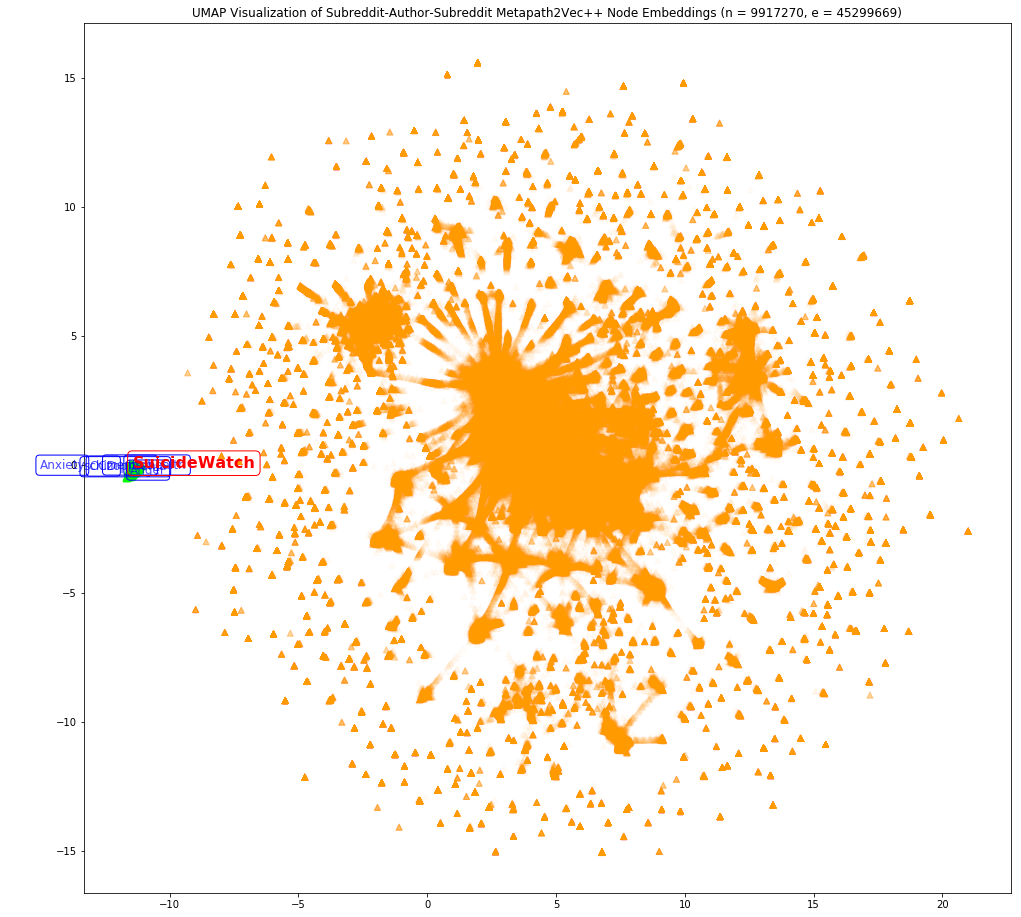

In [39]:
%%time
# Visualize the projected embeddings
plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_x_embeddings_mp2vpp, 
            node_y_embeddings_mp2vpp, 
            c=node_colours_mp2vpp,
            marker="^")

# Annotate the visualization
plt.title('UMAP Visualization of Subreddit-Author-Subreddit Metapath2Vec++ Node Embeddings (n = {}, e = {})'.format(
    graph.num_vertices(),
    graph.num_edges()))
for i,txt in enumerate(node_names_mp2vpp):
    if txt in MH_subreddits:
        if txt == "SuicideWatch":
            plt.text(node_x_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.0,size=1)[0]),
                     node_y_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.0,size=1)[0]),
                     txt,
                     fontweight='bold',
                     fontsize=16,
                     color=[255/255,0.,0.,1],
                     zorder=4,
                     bbox=dict(facecolor='none', edgecolor='red', boxstyle='round'))
        elif txt == "depression":
            plt.text(node_x_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=3,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "Anxiety":
            plt.text(node_x_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=3,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "mentalhealth":
            plt.text(node_x_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=3,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "OCD":
            plt.text(node_x_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=3,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "ptsd":
            plt.text(node_x_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=3,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "BPD":
            plt.text(node_x_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=3,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "schizophrenia":
            plt.text(node_x_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=3,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "Anger":
            plt.text(node_x_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=3,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "addiction":
            plt.text(node_x_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=3,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        else:
            plt.text(node_x_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=0.0,
                     zorder=3)
    elif txt in SH_subreddits:
        plt.text(node_x_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                 node_y_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                 txt,
                 fontsize=12,
                 color=[100/255,0.,255/255,.7],
                 alpha=0.0,
                 zorder=2)
    else:
        plt.text(node_x_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                 node_y_embeddings_mp2vpp[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                 txt,
                 fontsize=10,
                 alpha=0.0,
                 zorder=1)
        
plt.savefig('Figures/MultiRel_metapath2vecpp_orig_UMAP_cac_{}.png'.format(datetime.today().strftime('%Y_%m_%d')))
plt.show()

In [40]:
plt.close()

In [38]:
# Get SW's nearest neighbors
sim_sw_mp2vpp = []
for subr in MH_subreddits:
    try:
        subr_type_name = "v_"+subr
        sim_sw_mp2vpp.append([subr,model_mp2vpp.similarity("v_SuicideWatch", subr_type_name)])
    except:
        pass
for subr in SH_subreddits:
    try:
        subr_type_name = "v_"+subr
        sim_sw_mp2vpp.append([subr,model_mp2vpp.similarity("v_SuicideWatch", subr_type_name)])
    except:
        pass
sim_sw_mp2vpp = sorted(sim_sw_mp2vpp, key=itemgetter(1), reverse=True)
print("Similarity between SuicideWatch and ...")
for s in sim_sw_mp2vpp:
    print("  {}: {}".format(s[0],s[1]))

Similarity between SuicideWatch and ...
  SuicideWatch: 1.0
  depression: 0.9034441113471985
  selfharm: 0.8595550060272217
  Anxiety: 0.854195237159729
  Advice: 0.8540134429931641
  socialskills: 0.82252037525177
  BPD: 0.8178430795669556
  MMFB: 0.817115306854248
  ForeverAlone: 0.815471887588501
  offmychest: 0.8053249716758728
  offmychest: 0.8053249716758728
  mentalhealth: 0.8047873973846436
  Needafriend: 0.8006958961486816
  StopSelfHarm: 0.8004390001296997
  AskDocs: 0.7998802065849304
  socialanxiety: 0.7873457670211792
  needadvice: 0.7745763063430786
  aspergers: 0.7703750133514404
  schizophrenia: 0.7659317255020142
  BipolarReddit: 0.764685869216919
  NoFap: 0.7644622325897217
  ADHD: 0.7623977065086365
  leaves: 0.7585673332214355
  leaves: 0.7585673332214355
  CompulsiveSkinPicking: 0.747642993927002
  survivorsofabuse: 0.7472042441368103
  personalfinance: 0.7441964149475098
  LifeProTips: 0.7380039095878601
  GetMotivated: 0.736575722694397
  GetMotivated: 0.73657572

/home/amruch/anaconda3/envs/graph-tool/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


################################################################################
################################################################################

# ML Evaluations 1: graph embeddings only

## Import processed text data

In [ ]:
path_text = "/media/seagate0/reddit/samples/sample_main_50elsm_data_prep_dist.csv"
data_text = pd.read_csv(path_text)
data_text.dropna(inplace=True)
#data_text["text_prep"] = data_text["text_prep"].apply(lambda x: x.split())
print(data_text.shape)
data_text.head()

In [ ]:
# Get authors
authors_list = set(data_text["submission_author"].values)
print("authors_list len:", len(authors_list))
list(authors_list)[:10]

In [ ]:
# Get subreddits
subr_list = set(data_text["subreddit"].values)
print("subr_list len:", len(subr_list))
list(subr_list)[:10]

In [ ]:
# Get Boolean for whether author every posted in SW
SW_authors = data_text[data_text["subreddit"] == "SuicideWatch"]
SW_authors = set(SW_authors["submission_author"].values)
print("SW_authors len:", len(SW_authors))
list(SW_authors)[:10]

authors_y = {}
for author in set(data_text["submission_author"].values):
    if author in SW_authors:
        authors_y[author] = 1
    else:
        authors_y[author] = 0
print("authors_y len:", len(authors_y.keys()))
print("SW authors in authors_y:", sum(authors_y.values()))
list(authors_y.items())[:10]

## Truncated metapath2vec visualization

In [641]:
%%time
# Plot the transformed embeddings
node_colours_mp2v_t = []
node_markers_mp2v_t = []
node_names_mp2v_t   = []
node_targets_mp2v_t = []
node_x_embeddings_mp2v_t = []
node_y_embeddings_mp2v_t = []
y_name = []
y = []
X = []

# Color and annotate node by type and community
for i in range(len(node_ids_mp2v)):
    # Skip first entity (</s> token) in node_ids_mp2v
    if i == 0:
        continue
    # Convert appended name (eg, v_* ) to real name and get UMAP pos
    node_id   = names_ids[node_ids_mp2v[i]]
    node_name = node_ids_mp2v[i][2:]
    # Get node information if node in author or subreddit list
    if node_name in authors_list or node_name in subr_list:
        if graph.vp.type[node_id] == "subreddit":
            node_targets_mp2v_t.append(graph.vp.type[node_id])
            node_x_embeddings_mp2v_t.append(embeddings_2d_mp2v[:,0][i])
            node_y_embeddings_mp2v_t.append(embeddings_2d_mp2v[:,1][i])
            if graph.vp.MH_subreddits[node_id] == True:
                if node_name == "SuicideWatch":
                    node_markers_mp2v_t.append("P")
                    node_colours_mp2v_t.append([255/255,0.,0.,1])
                    node_names_mp2v_t.append(node_name)
                else:
                    node_markers_mp2v_t.append("^")
                    node_colours_mp2v_t.append([0.,0.,255/255,.5])
                    if random.random() < 1.1:
                        node_names_mp2v_t.append(node_name)
                    else:
                        node_names_mp2v_t.append('')
            elif graph.vp.SH_subreddits[node_id] == True:
                node_markers_mp2v_t.append("^")
                node_colours_mp2v_t.append([100/255,0.,255/255,.4])
                node_names_mp2v_t.append(node_name)
            else: #random subreddits
                node_markers_mp2v_t.append("^")
                node_colours_mp2v_t.append([0.,255/255,0.,.3])
                if random.random() < 0.01:
                    node_names_mp2v_t.append(node_name)
                else:
                    node_names_mp2v_t.append('')
        elif graph.vp.type[node_id] == "author":
            try:
                if authors_y[node_name] == 1:
                    if random.random() < 0.05:
                        node_names_mp2v_t.append("swauth")
                    else:
                        node_names_mp2v_t.append('')
                else:
                    node_names_mp2v_t.append('')
                y_name.append(node_name)
                y.append(authors_y[node_name])
                X.append(node_embeddings_mp2v[i])
            except:
                node_names_mp2v_t.append('')
                pass
            node_markers_mp2v_t.append(".")
            node_colours_mp2v_t.append([255/255,155/255,0.,.035])
            node_targets_mp2v_t.append(graph.vp.type[node_id])
            node_x_embeddings_mp2v_t.append(embeddings_2d_mp2v[:,0][i])
            node_y_embeddings_mp2v_t.append(embeddings_2d_mp2v[:,1][i])
        else: #submissions/comments (should be excluded from cac sample)
            raise ValueError("Unexpected value at node_ids_mp2v index", i)
            
print("node_names_mp2v_t len:", len(node_names_mp2v_t), "\n")
for i in list(zip(node_targets_mp2v_t[:20], node_colours_mp2v_t[:20])): print (i)
    
print("\nY[0] ({}) = {}\nX[0] = {}".format(y_name[0],y[0],X[0]))

node_names_mp2v_t len: 305097 

('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('author', [1.0, 0.6078431372549019, 0.0, 0.035])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('author', [1.0, 0.6078431372549019, 0.0, 0.035])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])

Y[0] (reddit) = 0
X[0] = [ 0.11 -0.47  0.36  0.11 -0.51  0.06  0.07 -0.02  0.17  0.75 -0.25  0.6
  0.66 -0.5  -0.15 -0.44  0.16 -0.28  0.25 -0.29 -0.29  0.63  0.1  -0.59
  0.12  0.42 -0.01 -0.86 -0.15  0.47 -0.23  0.4  

In [642]:
len(node_names_mp2v_t)

305097

In [643]:
len(node_x_embeddings_mp2v_t)

305097

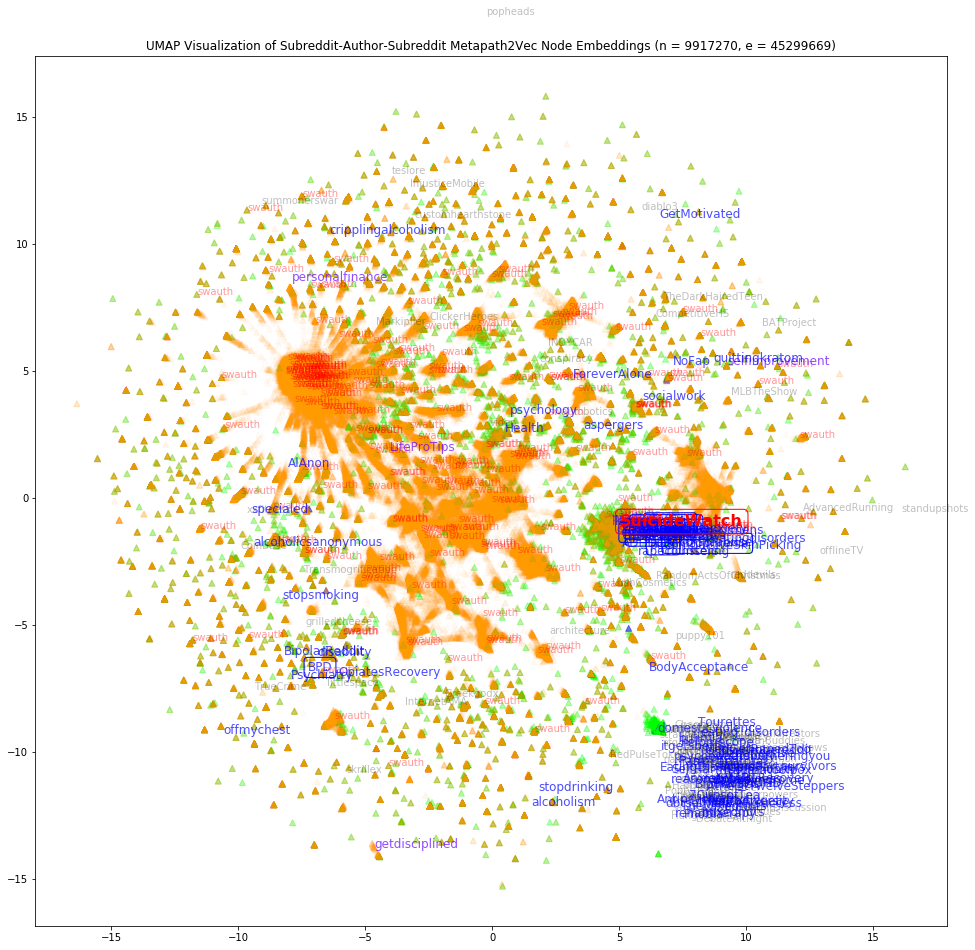

CPU times: user 2min 2s, sys: 1.93 s, total: 2min 4s
Wall time: 2min 3s


In [150]:
%%time
# Visualize the projected embeddings
plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
#plt.scatter(node_embeddings_2d_mp2v_t[:,0], 
#            node_embeddings_2d_mp2v_t[:,1], 
#            c=node_colours_mp2v_t,
#            marker="^")
plt.scatter(node_x_embeddings_mp2v_t, 
            node_y_embeddings_mp2v_t, 
            c=node_colours_mp2v_t,
            marker="^")

# Annotate the visualization
plt.title('UMAP Visualization of Subreddit-Author-Subreddit Metapath2Vec Node Embeddings (n = {}, e = {})'.format(
    graph.num_vertices(),
    graph.num_edges()))
for i,txt in enumerate(node_names_mp2v_t):
    if txt in MH_subreddits:
        if txt == "SuicideWatch":
            plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.0,size=1)[0]),
                     node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.0,size=1)[0]),
                     txt,
                     fontweight='bold',
                     fontsize=16,
                     color=[255/255,0.,0.,1],
                     zorder=6,
                     bbox=dict(facecolor='none', edgecolor='red', boxstyle='round'))
        elif txt == "depression":
            plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=5,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "Anxiety":
            plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=5,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "mentalhealth":
            plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=5,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "OCD":
            plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=5,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "ptsd":
            plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=5,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "BPD":
            plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=5,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "schizophrenia":
            plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=5,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "Anger":
            plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=5,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "addiction":
            plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=5,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        else:
            plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=4)
    elif txt in SH_subreddits:
        plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                 node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                 txt,
                 fontsize=12,
                 color=[100/255,0.,255/255,.7],
                 alpha=.7,
                 zorder=3)
    elif txt == "swauth":
        plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.0,size=1)[0]),
                 node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.0,size=1)[0]),
                 txt,
                 fontsize=10,
                 color=[255/255,0.,0.,.4],
                 alpha=.4,
                 zorder=2)
    else:
        plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                 node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                 txt,
                 fontsize=10,
                 alpha=.25,
                 zorder=1)
        
plt.savefig('Figures/MultiRel_metapath2vec_orig_UMAP_cac_t_{}.png'.format(datetime.today().strftime('%Y_%m_%d')))
plt.show()

In [152]:
plt.close()

## ML dataset prep

In [ ]:
# Downsample no-sw authors for training balance
y_samp_name = []
y_samp = []
X_samp = []

for i,(y_i,X_i) in enumerate(zip(y,X)):
    if y_i == 1:
        y_samp_name.append(y_name[i])
        y_samp.append(y_i)
        X_samp.append(X_i)
    else:
        if random.random() < 0.02: #0.02 --> 75/65
            y_samp_name.append(y_name[i])
            y_samp.append(y_i)
            X_samp.append(X_i)
        else:
            continue

print("SW authors in y_samp:    ", sum(y_samp))
print("non-SW authors in y_samp:", len(y_samp)-sum(y_samp))
print("y_samp len:", len(y_samp))
print("y_samp_name len:", len(y_samp_name))
print("y_samp_name examples:", y_samp_name[:10])

In [726]:
# Split data into training/test sets
X_train, X_test, y_train, y_test = train_test_split(
    np.array(X_samp),
    np.array(y_samp),
    test_size=0.20,
    shuffle=True,
    stratify=np.array(y_samp),
    random_state=407)
print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
    X_train.shape, y_train.shape, X_test.shape, y_test.shape))
print("SW authors in y_train:", sum(y_train))
print("SW authors in y_test: ", sum(y_test))

Array shapes:
 X_train = (8610, 128)
 y_train = (8610,)
 X_test = (2153, 128)
 y_test = (2153,)
SW authors in y_train: 4060
SW authors in y_test:  1015


## Node prediction

In [727]:
# Predict if author posts in SW
clf_logit = LogisticRegressionCV(cv=5, 
    scoring="recall",
    multi_class='ovr',
    verbose=1,
    n_jobs=32)
clf_logit.fit(X_train, y_train)
y_pred = clf_logit.predict(X_test)

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   5 out of   5 | elapsed:   15.2s finished


In [728]:
metrics.accuracy_score(y_test, y_pred)

0.6874129122155133

In [729]:
metrics.f1_score(y_test, y_pred)

0.6507524649714583

Confusion matrix, without normalization
[[853 285]
 [388 627]]
Normalized confusion matrix
[[0.75 0.25]
 [0.38 0.62]]


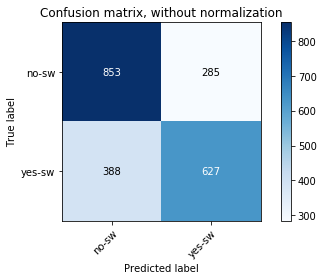

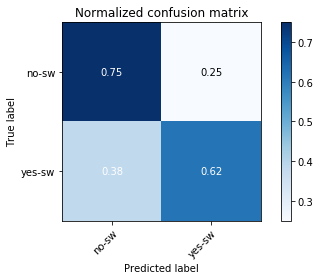

In [730]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [731]:
# Initialize grid search
best_fit = [0,(), 0, None]

In [732]:
# Set grid search parameters
clf_mlp__hidden_layer_sizes = (
    (200,50,25),
    (200,50),
)

clf_mlp__clf_mlp__alpha = (0.0001, 0.00001, 0.00001)

clf_mlp__batch_size = (32, 100, 'auto')

In [733]:
# Run grid search for best prediction by recall
for hlayers in clf_mlp__hidden_layer_sizes:
    for a in clf_mlp__alpha:
        for b in clf_mlp__batch_size:
            print("Fitting MLP with", hlayers, "and", a, "for", b, "...")
            clf_mlp = MLPClassifier(
                hidden_layer_sizes=hlayers,
                alpha = a,
                batch_size = b,
                early_stopping=True,
                n_iter_no_change=30,
                random_state=407)
            clf_mlp.fit(X_train, y_train)
            y_pred = clf_mlp.predict(X_test)
            recallscore = metrics.recall_score(y_test, y_pred)
            if recallscore > best_fit[0]:
                best_fit = [recallscore, hlayers, a, b]
                print("  --> new best fit:", best_fit)
            
print("Best fit [recall, hlayers, alpha, batch size]:", best_fit)

Fitting MLP with (200, 50, 25) and 0.0001 for 32 ...
  --> new best fit: [0.5241379310344828, (200, 50, 25), 0.0001, 32]
Fitting MLP with (200, 50, 25) and 0.0001 for 100 ...
Fitting MLP with (200, 50, 25) and 0.0001 for auto ...
  --> new best fit: [0.5881773399014778, (200, 50, 25), 0.0001, 'auto']
Fitting MLP with (200, 50, 25) and 1e-05 for 32 ...
Fitting MLP with (200, 50, 25) and 1e-05 for 100 ...
Fitting MLP with (200, 50, 25) and 1e-05 for auto ...
Fitting MLP with (200, 50) and 0.0001 for 32 ...
Fitting MLP with (200, 50) and 0.0001 for 100 ...
Fitting MLP with (200, 50) and 0.0001 for auto ...
Fitting MLP with (200, 50) and 1e-05 for 32 ...
Fitting MLP with (200, 50) and 1e-05 for 100 ...
Fitting MLP with (200, 50) and 1e-05 for auto ...
Best fit [recall, hlayers, alpha, batch size]: [0.5881773399014778, (200, 50, 25), 0.0001, 'auto']


In [734]:
# Fit best performing multilayer perceptron
clf_mlp = MLPClassifier(
    hidden_layer_sizes=best_fit[1],
    alpha = best_fit[2],
    batch_size = best_fit[3],
    early_stopping=True,
    n_iter_no_change=30,
    random_state=407)
clf_mlp.fit(X_train, y_train)
y_pred = clf_mlp.predict(X_test)

In [735]:
metrics.accuracy_score(y_test, y_pred)

0.6925220622387367

In [736]:
metrics.f1_score(y_test, y_pred)

0.6433189655172413

Confusion matrix, without normalization
[[894 244]
 [418 597]]
Normalized confusion matrix
[[0.79 0.21]
 [0.41 0.59]]


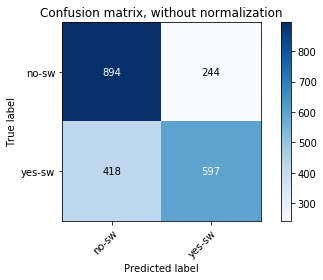

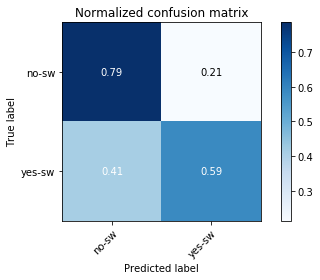

In [737]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [738]:
clf_etree = ExtraTreesClassifier(n_estimators=200, random_state=407, n_jobs=-1)
clf_etree.fit(X_train, y_train)
y_pred = clf_etree.predict(X_test)

In [739]:
scores = cross_val_score(clf_etree, X_train, y_train, cv=5)
scores.mean()

0.6782810685249709

In [740]:
metrics.accuracy_score(y_test, y_pred)

0.6888063167673014

In [741]:
metrics.f1_score(y_test, y_pred)

0.6153846153846153

Confusion matrix, without normalization
[[947 191]
 [479 536]]
Normalized confusion matrix
[[0.83 0.17]
 [0.47 0.53]]


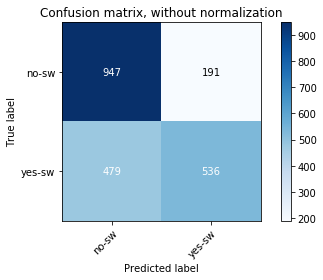

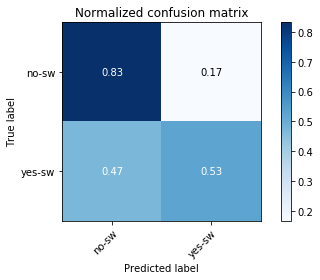

In [742]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [743]:
clf_adaboost = AdaBoostClassifier(n_estimators=400, random_state=407)
clf_adaboost.fit(X_train, y_train)
y_pred = clf_adaboost.predict(X_test)

In [744]:
scores = cross_val_score(clf_adaboost, X_train, y_train, cv=5)
scores.mean()

0.6531939605110336

In [745]:
metrics.accuracy_score(y_test, y_pred)

0.6539712029725964

In [746]:
metrics.f1_score(y_test, y_pred)

0.6250629089079014

Confusion matrix, without normalization
[[787 351]
 [394 621]]
Normalized confusion matrix
[[0.69 0.31]
 [0.39 0.61]]


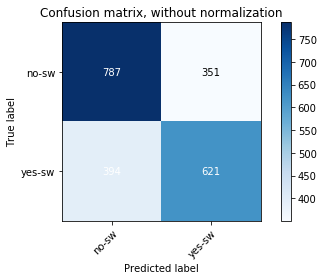

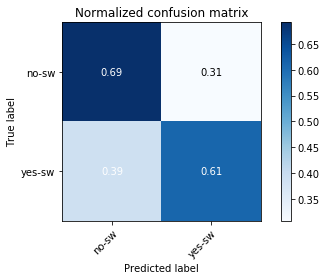

In [747]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [748]:
clf_gboost = GradientBoostingClassifier(n_estimators=400, learning_rate=1.0, random_state=407)
clf_gboost.fit(X_train, y_train)
y_pred = clf_gboost.predict(X_test)

In [749]:
scores = cross_val_score(clf_gboost, X_train, y_train, cv=5)
scores.mean()

0.6332171893147504

In [750]:
metrics.accuracy_score(y_test, y_pred)

0.6228518346493265

In [751]:
metrics.f1_score(y_test, y_pred)

0.5968222442899702

Confusion matrix, without normalization
[[740 398]
 [414 601]]
Normalized confusion matrix
[[0.65 0.35]
 [0.41 0.59]]


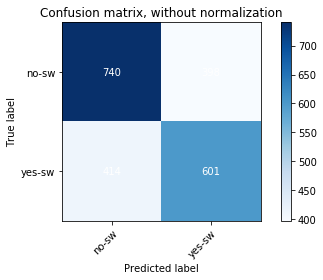

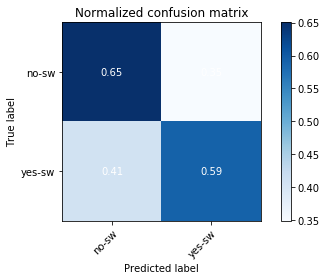

In [752]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [753]:
eclf = VotingClassifier(
    estimators=[
        ('mlp', clf_mlp),
        ('etree', clf_etree),
        ('adaboost', clf_adaboost),
        ('gboost', clf_gboost)],
    voting='hard')
eclf.fit(X_train, y_train)
y_pred = eclf.predict(X_test)

In [754]:
eclf = cross_val_score(eclf, X_train, y_train, cv=5)
scores.mean()

0.6332171893147504

In [755]:
metrics.accuracy_score(y_test, y_pred)

0.6939154667905248

In [756]:
metrics.f1_score(y_test, y_pred)

0.6143943826799297

Confusion matrix, without normalization
[[969 169]
 [490 525]]
Normalized confusion matrix
[[0.85 0.15]
 [0.48 0.52]]


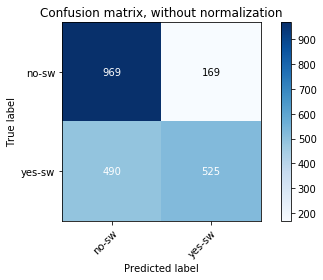

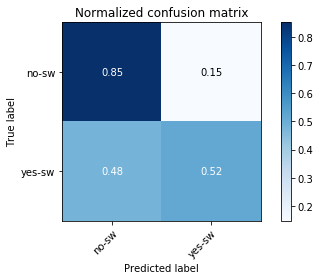

In [757]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Adding in distance to SuicideWatch

In [ ]:
X_samp_mp2v_swdist = []

for i,name in enumerate(y_samp_name):
    temp_data = list(X_samp[i])
    swdist = model_mp2v.similarity("v_SuicideWatch", "a_"+name)
    temp_data.append(swdist)
    X_samp_mp2v_swdist.append(temp_data)
    
X_samp_mp2v_swdist = np.array(X_samp_mp2v_swdist)
np.nan_to_num(0.0)
X_samp_mp2v_swdist = np.nan_to_num(X_samp_mp2v_swdist)

print("SW authors in y_samp:    ", sum(y_samp))
print("non-SW authors in y_samp:", len(y_samp)-sum(y_samp))
print("y_samp_name len:", len(y_samp_name))
print("y_samp_name examples:", y_samp_name[:10])
print("x_samp_full shape:", X_samp_mp2v_swdist.shape)
print("x_samp_full[0]:", X_samp_mp2v_swdist[0])

In [759]:
# Split data into training/test sets
X_train, X_test, y_train, y_test = train_test_split(
    np.array(X_samp_mp2v_swdist),
    np.array(y_samp),
    test_size=0.20,
    shuffle=True,
    stratify=np.array(y_samp),
    random_state=407)
print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
    X_train.shape, y_train.shape, X_test.shape, y_test.shape))
print("SW authors in y_train:", sum(y_train))
print("SW authors in y_test: ", sum(y_test))

Array shapes:
 X_train = (8610, 129)
 y_train = (8610,)
 X_test = (2153, 129)
 y_test = (2153,)
SW authors in y_train: 4060
SW authors in y_test:  1015


In [760]:
clf_logit = LogisticRegressionCV(cv=5, 
    scoring="recall",
    multi_class='ovr',
    verbose=1,
    n_jobs=32)
clf_logit.fit(X_train, y_train)

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   5 out of   5 | elapsed:   16.2s finished


LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=32, penalty='l2', random_state=None,
           refit=True, scoring='recall', solver='lbfgs', tol=0.0001,
           verbose=1)

In [761]:
y_pred = clf_logit.predict(X_test)

In [762]:
metrics.accuracy_score(y_test, y_pred)

0.6892707849512308

In [763]:
metrics.f1_score(y_test, y_pred)

0.6513809275664408

Confusion matrix, without normalization
[[859 279]
 [390 625]]
Normalized confusion matrix
[[0.75 0.25]
 [0.38 0.62]]


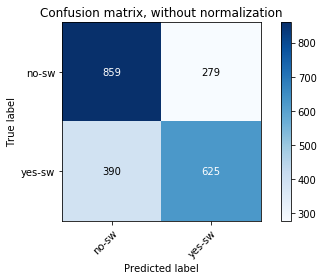

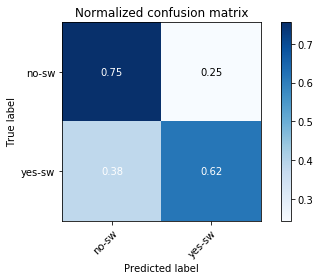

In [764]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

################################################################################
################################################################################

# ML Evaluations 2: graph + doc embeddings

### Load Doc2Vec models (if necessary)

In [5]:
model_dbow = gensim.models.doc2vec.Doc2Vec.load("/media/seagate0/reddit/models/doc2vec_dbow50_sample_main_50elsm.model")
print("Loaded model:", model_dbow)

Loaded model: Doc2Vec(dbow,d50,n5,mc2,s0.001,t32)


In [27]:
model_dmm = gensim.models.doc2vec.Doc2Vec.load("/media/seagate0/reddit/models/doc2vec_dmm50_sample_main_50elsm.model")
print("Loaded model:", model_dmm)

Loaded model: Doc2Vec(dm/m,d50,n5,w10,mc2,s0.001,t32)


### Get author embeddings

In [765]:
swdist_dbow_n    = {}
swdist_dbow_mean = {}
swdist_dbow_sd   = {}
swdist_dmm_n     = {}
swdist_dmm_mean  = {}
swdist_dmm_sd    = {}

swdist_authors = data_text.groupby("submission_author").groups.keys()

swdist_dbow_n_list = data_text.groupby("submission_author")["sw_dist"].count()
swdist_dbow_n_list = list(zip(swdist_authors, swdist_dbow_n_list))
swdist_dbow_n = {auth:dist for (auth,dist) in swdist_dbow_n_list}
print("swdist_dbow_n len:", len(swdist_dbow_n))

swdist_dbow_mean_list = data_text.groupby("submission_author")["sw_dist"].mean()
swdist_dbow_mean_list = list(zip(swdist_authors, swdist_dbow_mean_list))
swdist_dbow_mean = {auth:dist for (auth,dist) in swdist_dbow_mean_list}
print("swdist_dbow_mean len:", len(swdist_dbow_mean))

swdist_dbow_sd_list = data_text.groupby("submission_author")["sw_dist"].std()
swdist_dbow_sd_list = list(zip(swdist_authors, swdist_dbow_sd_list))
swdist_dbow_sd = {auth:dist for (auth,dist) in swdist_dbow_sd_list}
print("swdist_dbow_sd len:", len(swdist_dbow_sd))

swdist_dmm_n_list = data_text.groupby("submission_author")["sw_dist_dmm"].count()
swdist_dmm_n_list = list(zip(swdist_authors, swdist_dmm_n_list))
swdist_dmm_n = {auth:dist for (auth,dist) in swdist_dmm_n_list}
print("swdist_dmm_n len:", len(swdist_dmm_n))

swdist_dmm_mean_list = data_text.groupby("submission_author")["sw_dist_dmm"].mean()
swdist_dmm_mean_list = list(zip(swdist_authors, swdist_dmm_mean_list))
swdist_dmm_mean = {auth:dist for (auth,dist) in swdist_dmm_mean_list}
print("swdist_dmm_mean len:", len(swdist_dmm_mean))

swdist_dmm_sd_list = data_text.groupby("submission_author")["sw_dist_dmm"].std()
swdist_dmm_sd_list = list(zip(swdist_authors, swdist_dmm_sd_list))
swdist_dmm_sd = {auth:dist for (auth,dist) in swdist_dmm_sd_list}
print("swdist_dmm_sd len:", len(swdist_dmm_sd))

swdist_dbow_n len: 689500
swdist_dbow_mean len: 689500
swdist_dbow_sd len: 689500
swdist_dmm_n len: 689500
swdist_dmm_mean len: 689500
swdist_dmm_sd len: 689500


In [ ]:
print(list(swdist_dbow_n.items())[:10], "\n")
print(list(swdist_dbow_mean.items())[:10], "\n")
print(list(swdist_dbow_sd.items())[:10])

In [767]:
print(len(y_samp_name))
print(len(y_samp))
print(len(X_samp))

10763
10763
10763


### d2v everything

In [ ]:
# Setup dataset
X_samp_full = []

for i,name in enumerate(y_samp_name):
    temp_data = list(X_samp[i])
    temp_data.append(swdist_dbow_n[name])
    temp_data.append(swdist_dbow_mean[name])
    if swdist_dbow_sd[name] != 'nan':
        temp_data.append(swdist_dbow_sd[name])
    else:
        temp_data.append(0.0)
    temp_data.append(swdist_dmm_n[name])
    temp_data.append(swdist_dmm_mean[name])
    if str(swdist_dmm_sd[name]) != 'nan':
        temp_data.append(swdist_dmm_sd[name])
    else:
        temp_data.append(0.0)
    temp_data.append(swdist_dmm_sd[name])
    X_samp_full.append(temp_data)
    
X_samp_full = np.array(X_samp_full)
np.nan_to_num(0.0)
X_samp_full = np.nan_to_num(X_samp_full)

print("SW authors in y_samp:    ", sum(y_samp))
print("non-SW authors in y_samp:", len(y_samp)-sum(y_samp))
print("y_samp_name len:", len(y_samp_name))
print("y_samp_name examples:", y_samp_name[:10])
print("x_samp_full shape:", X_samp_full.shape)
print("x_samp_full[0]:", X_samp_full[0])

In [769]:
# Split data into training/test sets
X_train, X_test, y_train, y_test = train_test_split(
    np.array(X_samp_full),
    np.array(y_samp),
    test_size=0.20,
    shuffle=True,
    stratify=np.array(y_samp),
    random_state=407)
print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
    X_train.shape, y_train.shape, X_test.shape, y_test.shape))
print("SW authors in y_train:", sum(y_train))
print("SW authors in y_test: ", sum(y_test))

Array shapes:
 X_train = (8610, 135)
 y_train = (8610,)
 X_test = (2153, 135)
 y_test = (2153,)
SW authors in y_train: 4060
SW authors in y_test:  1015


In [770]:
# Predict if author posts in SW
clf_logit = LogisticRegressionCV(cv=5, 
    scoring="recall",
    multi_class='ovr',
    verbose=1,
    n_jobs=32)
clf_logit.fit(X_train, y_train)

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   2 out of   5 | elapsed:    5.3s remaining:    8.0s
[Parallel(n_jobs=32)]: Done   5 out of   5 | elapsed:    5.8s finished
/home/amruch/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=32, penalty='l2', random_state=None,
           refit=True, scoring='recall', solver='lbfgs', tol=0.0001,
           verbose=1)

In [771]:
y_pred = clf_logit.predict(X_test)

In [772]:
metrics.accuracy_score(y_test, y_pred)

0.9326521133302369

In [773]:
metrics.f1_score(y_test, y_pred)

0.9295089936801166

Confusion matrix, without normalization
[[1052   86]
 [  59  956]]
Normalized confusion matrix
[[0.92 0.08]
 [0.06 0.94]]


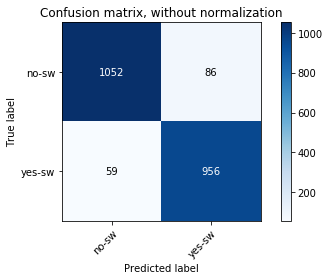

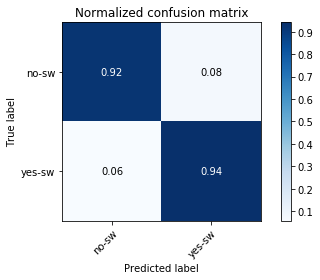

In [774]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [775]:
eclf = VotingClassifier(
    estimators=[
        ('mlp', clf_mlp),
        ('etree', clf_etree),
        ('adaboost', clf_adaboost),
        ('gboost', clf_gboost)],
    voting='hard')

clf_mlp.fit(X_train, y_train)
clf_etree.fit(X_train, y_train)
clf_adaboost.fit(X_train, y_train)
clf_gboost.fit(X_train, y_train)
eclf.fit(X_train, y_train)

y_pred = eclf.predict(X_test)

In [776]:
metrics.accuracy_score(y_test, y_pred)

0.929400836042731

In [777]:
metrics.f1_score(y_test, y_pred)

0.9251968503937008

Confusion matrix, without normalization
[[1061   77]
 [  75  940]]
Normalized confusion matrix
[[0.93 0.07]
 [0.07 0.93]]


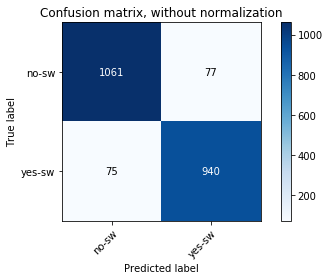

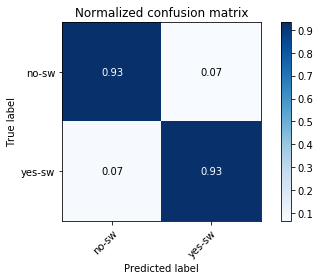

In [778]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### d2v means only

In [ ]:
X_samp_d2v = []

for i,name in enumerate(y_samp_name):
    temp_data = []
    temp_data.append(swdist_dbow_mean[name])
    temp_data.append(swdist_dmm_mean[name])
    X_samp_d2v.append(temp_data)
    
X_samp_d2v = np.array(X_samp_d2v)
np.nan_to_num(0.0)
X_samp_d2v = np.nan_to_num(X_samp_d2v)

print("SW authors in y_samp:    ", sum(y_samp))
print("non-SW authors in y_samp:", len(y_samp)-sum(y_samp))
print("y_samp_name len:", len(y_samp_name))
print("y_samp_name examples:", y_samp_name[:10])
print("X_samp_d2v shape:", X_samp_d2v.shape)
print("X_samp_d2v[0]:", X_samp_d2v[0])

In [780]:
# Split data into training/test sets
X_train, X_test, y_train, y_test = train_test_split(
    np.array(X_samp_d2v),
    np.array(y_samp),
    test_size=0.20,
    shuffle=True,
    stratify=np.array(y_samp),
    random_state=407)
print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
    X_train.shape, y_train.shape, X_test.shape, y_test.shape))
print("SW authors in y_train:", sum(y_train))
print("SW authors in y_test: ", sum(y_test))

Array shapes:
 X_train = (8610, 2)
 y_train = (8610,)
 X_test = (2153, 2)
 y_test = (2153,)
SW authors in y_train: 4060
SW authors in y_test:  1015


In [781]:
clf_logit = LogisticRegressionCV(cv=5, 
    scoring="recall",
    multi_class='ovr',
    verbose=1,
    n_jobs=32)
clf_logit.fit(X_train, y_train)

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   2 out of   5 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=32)]: Done   5 out of   5 | elapsed:    0.7s finished


LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=32, penalty='l2', random_state=None,
           refit=True, scoring='recall', solver='lbfgs', tol=0.0001,
           verbose=1)

In [782]:
y_pred = clf_logit.predict(X_test)

In [783]:
metrics.accuracy_score(y_test, y_pred)

0.7617278216442174

In [784]:
metrics.f1_score(y_test, y_pred)

0.7425990968389363

Confusion matrix, without normalization
[[900 238]
 [275 740]]
Normalized confusion matrix
[[0.79 0.21]
 [0.27 0.73]]


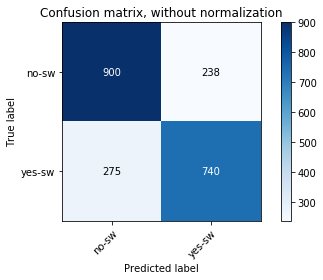

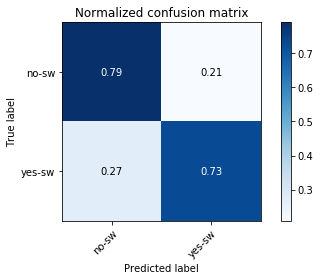

In [785]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### d2v means and sds

In [ ]:
X_samp_d2v = []

for i,name in enumerate(y_samp_name):
    temp_data = []
    temp_data.append(swdist_dbow_mean[name])
    if swdist_dbow_sd[name] != 'nan':
        temp_data.append(swdist_dbow_sd[name])
    else:
        temp_data.append(0.0)
    temp_data.append(swdist_dmm_mean[name])
    if str(swdist_dmm_sd[name]) != 'nan':
        temp_data.append(swdist_dmm_sd[name])
    else:
        temp_data.append(0.0)
    temp_data.append(swdist_dmm_sd[name])
    X_samp_d2v.append(temp_data)
    
X_samp_d2v = np.array(X_samp_d2v)
np.nan_to_num(0.0)
X_samp_d2v = np.nan_to_num(X_samp_d2v)

print("SW authors in y_samp:    ", sum(y_samp))
print("non-SW authors in y_samp:", len(y_samp)-sum(y_samp))
print("y_samp_name len:", len(y_samp_name))
print("y_samp_name examples:", y_samp_name[:10])
print("X_samp_d2v shape:", X_samp_d2v.shape)
print("X_samp_d2v[0]:", X_samp_d2v[0])

In [787]:
# Split data into training/test sets
X_train, X_test, y_train, y_test = train_test_split(
    np.array(X_samp_d2v),
    np.array(y_samp),
    test_size=0.20,
    shuffle=True,
    stratify=np.array(y_samp),
    random_state=407)
print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
    X_train.shape, y_train.shape, X_test.shape, y_test.shape))
print("SW authors in y_train:", sum(y_train))
print("SW authors in y_test: ", sum(y_test))

Array shapes:
 X_train = (8610, 5)
 y_train = (8610,)
 X_test = (2153, 5)
 y_test = (2153,)
SW authors in y_train: 4060
SW authors in y_test:  1015


In [788]:
clf_logit = LogisticRegressionCV(cv=5, 
    scoring="recall",
    multi_class='ovr',
    verbose=1,
    n_jobs=32)
clf_logit.fit(X_train, y_train)

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.3s
[Parallel(n_jobs=32)]: Done   5 out of   5 | elapsed:    1.0s finished


LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=32, penalty='l2', random_state=None,
           refit=True, scoring='recall', solver='lbfgs', tol=0.0001,
           verbose=1)

In [789]:
y_pred = clf_logit.predict(X_test)

In [790]:
metrics.accuracy_score(y_test, y_pred)

0.8913144449605203

In [791]:
metrics.f1_score(y_test, y_pred)

0.8886774500475738

Confusion matrix, without normalization
[[985 153]
 [ 81 934]]
Normalized confusion matrix
[[0.87 0.13]
 [0.08 0.92]]


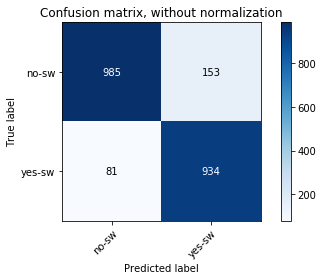

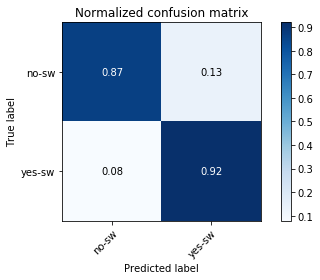

In [792]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Prediction: full SW sample
#### (Test on all 305K submission author observations)

In [ ]:
# Setup dataset
X_d2v = []

for i,name in enumerate(y_name):
    temp_data = list(X[i])
    temp_data.append(swdist_dbow_mean[name])
    if swdist_dbow_sd[name] != 'nan':
        temp_data.append(swdist_dbow_sd[name])
    else:
        temp_data.append(0.0)
    temp_data.append(swdist_dmm_mean[name])
    if str(swdist_dmm_sd[name]) != 'nan':
        temp_data.append(swdist_dmm_sd[name])
    else:
        temp_data.append(0.0)
    temp_data.append(swdist_dmm_sd[name])
    X_d2v.append(temp_data)
    
X_d2v = np.array(X_d2v)
np.nan_to_num(0.0)
X_d2v = np.nan_to_num(X_d2v)

print("SW authors in y:    ", sum(y))
print("non-SW authors in y:", len(y)-sum(y))
print("y_name len:", len(y_name))
print("y_name examples:", y_name[:10])
print("X_d2v shape:", X_d2v.shape)
print("X_d2v[0]:", X_d2v[0])

In [850]:
# Split data into training/test sets
X_train = []
X_test  = []
y_train = []
y_test  = []
y_test_index = []

data_train = list(zip(y, X_d2v))
for i,(yi,Xi) in enumerate(data_train):
    if yi == 1:
        if random.random() < 0.8:
            y_train.append(yi)
            X_train.append(Xi)
        else:
            y_test_index.append(i)
            y_test.append(yi)
            X_test.append(Xi)
    if yi == 0:
        if random.random() < 0.02:
            y_train.append(yi)
            X_train.append(Xi)
        else:
            y_test_index.append(i)
            y_test.append(yi)
            X_test.append(Xi)

X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
    X_train.shape, y_train.shape, X_test.shape, y_test.shape))
print("SW authors in y_train:    ", sum(y_train))
print("non-SW authors in y_train:", len(y_train)-sum(y_train))
print("SW authors in y_test:     ", sum(y_test))
print("non-SW authors in y_test: ", len(y_test)-sum(y_test))
print("y_test_index len:", len(y_test_index))

Array shapes:
 X_train = (9865, 133)
 y_train = (9865,)
 X_test = (283638, 133)
 y_test = (283638,)
SW authors in y_train:     4073
non-SW authors in y_train: 5792
SW authors in y_test:      1002
non-SW authors in y_test:  282636
y_test_index len: 283638


In [851]:
# Predict if author posts in SW
clf_logit = LogisticRegressionCV(cv=5, 
    scoring="recall",
    multi_class='ovr',
    verbose=1,
    n_jobs=32)
clf_logit.fit(X_train, y_train)
y_pred = clf_logit.predict(X_test)

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   5 out of   5 | elapsed:   18.2s finished


In [852]:
metrics.accuracy_score(y_test, y_pred)

0.9007079446336528

In [853]:
metrics.f1_score(y_test, y_pred)

0.05869180119656405

Confusion matrix, without normalization
[[254597  28039]
 [   124    878]]
Normalized confusion matrix
[[0.9  0.1 ]
 [0.12 0.88]]


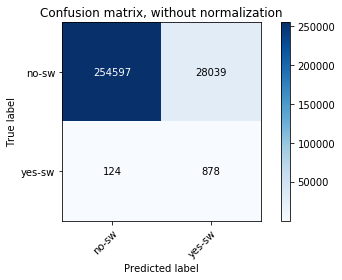

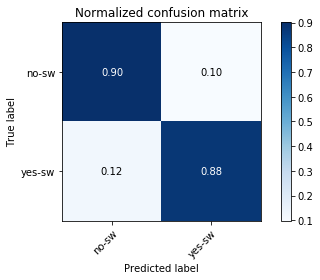

In [854]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [856]:
eclf = VotingClassifier(
    estimators=[
        ('lr', clf_logit),
        ('mlp', clf_mlp),
        ('etree', clf_etree),
        ('adaboost', clf_adaboost),
        ('gboost', clf_gboost)],
    voting='hard')

clf_mlp.fit(X_train, y_train)
clf_etree.fit(X_train, y_train)
clf_adaboost.fit(X_train, y_train)
clf_gboost.fit(X_train, y_train)
eclf.fit(X_train, y_train)

y_pred = eclf.predict(X_test)

[Parallel(n_jobs=32)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=32)]: Done   5 out of   5 | elapsed:    4.4s finished


In [857]:
metrics.accuracy_score(y_test, y_pred)

0.9075864305911056

In [858]:
metrics.f1_score(y_test, y_pred)

0.06412453584690088

Confusion matrix, without normalization
[[256528  26108]
 [   104    898]]
Normalized confusion matrix
[[0.91 0.09]
 [0.1  0.9 ]]


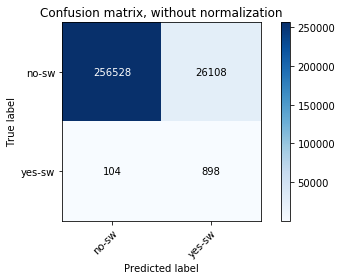

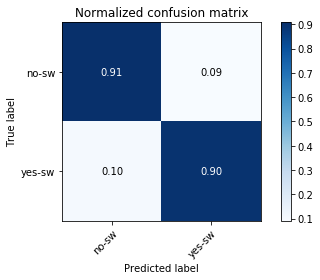

In [859]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=np.array(["no-sw","yes-sw"]), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Prediction visualizations

In [860]:
# Get predictions from ensemble model
y_pred = eclf.predict(X_test)

In [871]:
# Get prediction and graph embedding position for authors
y_pred_info = []
for i,idx in enumerate(y_test_index):
    y_pred_info_temp = []
    y_pred_info_temp.append(y_pred[i])
    y_pred_info_temp.append(node_x_embeddings_mp2v_t[idx])
    y_pred_info_temp.append(node_y_embeddings_mp2v_t[idx])
    y_pred_info.append(y_pred_info_temp)
print(len(y_pred_info))
y_pred_info[:10]

283638


[[0, -8.371717, 5.119131],
 [0, 9.417007, 0.40136793],
 [0, -4.1266465, 2.465238],
 [0, 1.206091, -0.20201455],
 [0, -3.9481068, -0.9653959],
 [0, -0.21843316, -1.7161578],
 [0, -4.1192927, 2.4637408],
 [0, -6.6187034, -8.994109],
 [0, 1.66221, 1.8805239],
 [0, 9.35177, 0.33333606]]

In [872]:
# Get embedding positions for subreddits
for i,node_type in enumerate(node_targets_mp2v_t):
    if node_type=="subreddit":
        y_pred_info.append([-1, node_x_embeddings_mp2v_t[i], node_y_embeddings_mp2v_t[i]])
print(len(y_pred_info))
print(y_pred_info[-10:])

295206
[[-1, 6.564476, -9.066076], [-1, 6.55787, -9.075684], [-1, 6.5708575, -9.074915], [-1, 6.5512614, -9.059785], [-1, 6.5731173, -9.088243], [-1, 6.5633283, -9.064607], [-1, 6.57062, -9.072494], [-1, 6.570015, -9.082308], [-1, 6.5687237, -9.071419], [-1, 6.5595284, -9.073402]]


In [895]:
# Prepare visualization annotations
y_pred_color = []
y_pred_xcord = []
y_pred_ycord = []
y_pred_pred  = []
for (p,xi,yi) in y_pred_info:
    if p == -1:
        y_pred_color.append("lime")
        y_pred_xcord.append(xi)
        y_pred_ycord.append(yi)
        y_pred_pred.append(0)
    elif p == 1:
        y_pred_color.append("red")
        y_pred_xcord.append(xi)
        y_pred_ycord.append(yi)
        y_pred_pred.append(1)
    else:
        y_pred_color.append("orange")
        y_pred_xcord.append(xi)
        y_pred_ycord.append(yi)
        y_pred_pred.append(0)
print("y_pred_color len:", len(y_pred_color))
print(y_pred_color[:50])
print(y_pred_color[-10:])

y_pred_color len: 295206
['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'red', 'orange', 'orange', 'red', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'red']
['lime', 'lime', 'lime', 'lime', 'lime', 'lime', 'lime', 'lime', 'lime', 'lime']


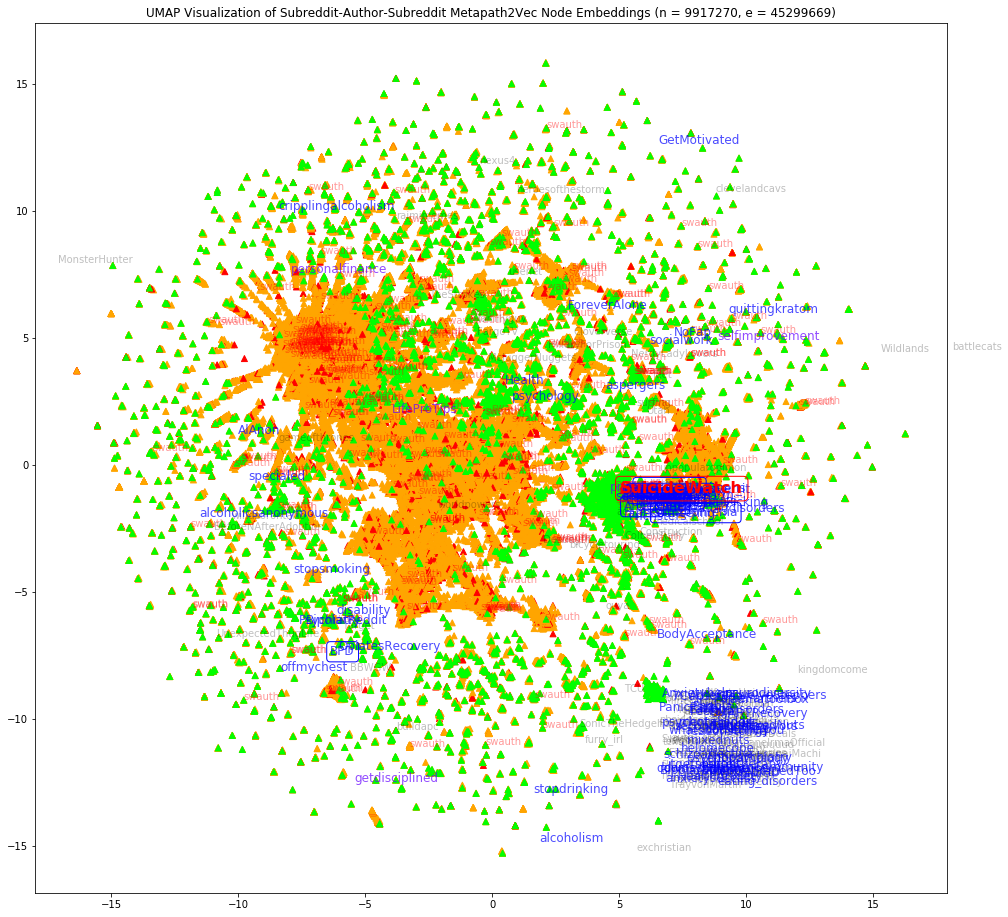

CPU times: user 1min 50s, sys: 3.3 s, total: 1min 53s
Wall time: 1min 50s


In [891]:
%%time
# Visualize predictions in projected embedding
plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
#plt.scatter(node_embeddings_2d_mp2v_t[:,0], 
#            node_embeddings_2d_mp2v_t[:,1], 
#            c=node_colours_mp2v_t,
#            marker="^")
plt.scatter(y_pred_xcord, 
            y_pred_ycord, 
            c=y_pred_color,
            marker="^")

# Annotate visualization
plt.title('UMAP Visualization of Subreddit-Author-Subreddit Metapath2Vec Node Embeddings (n = {}, e = {})'.format(
    graph.num_vertices(),
    graph.num_edges()))
for i,txt in enumerate(node_names_mp2v_t):
    if txt in MH_subreddits:
        if txt == "SuicideWatch":
            plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.0,size=1)[0]),
                     node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.0,size=1)[0]),
                     txt,
                     fontweight='bold',
                     fontsize=16,
                     color=[255/255,0.,0.,1],
                     zorder=6,
                     bbox=dict(facecolor='none', edgecolor='red', boxstyle='round'))
        elif txt == "depression":
            plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=5,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "Anxiety":
            plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=5,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "mentalhealth":
            plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=5,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "OCD":
            plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=5,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "ptsd":
            plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=5,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "BPD":
            plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=5,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "schizophrenia":
            plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=5,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "Anger":
            plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=5,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "addiction":
            plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=5,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        else:
            plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=4)
    elif txt in SH_subreddits:
        plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                 node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                 txt,
                 fontsize=12,
                 color=[100/255,0.,255/255,.7],
                 alpha=.7,
                 zorder=3)
    elif txt == "swauth":
        plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.0,size=1)[0]),
                 node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.0,size=1)[0]),
                 txt,
                 fontsize=10,
                 color=[255/255,0.,0.,.4],
                 alpha=.4,
                 zorder=2)
    else:
        plt.text(node_x_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                 node_y_embeddings_mp2v_t[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                 txt,
                 fontsize=10,
                 alpha=.25,
                 zorder=1)
        
plt.savefig('Figures/MultiRel_metapath2vec_orig_UMAP_cac_t_pred_{}.png'.format(datetime.today().strftime('%Y_%m_%d')))
plt.show()

In [896]:
plt.close()

In [990]:
# Create visualization info dataframe
viz_df = pd.DataFrame(
    np.column_stack([y_pred_pred, y_pred_xcord, y_pred_ycord, y_pred_color]),
    columns=['y_pred_pred', 'y_pred_xcord', 'y_pred_ycord', 'y_pred_color'])
viz_df['y_pred_pred'] = pd.to_numeric(viz_df['y_pred_pred'], errors='coerce')
viz_df['y_pred_xcord'] = pd.to_numeric(viz_df['y_pred_xcord'], errors='coerce')
viz_df['y_pred_ycord'] = pd.to_numeric(viz_df['y_pred_ycord'], errors='coerce')
print(viz_df.shape)
viz_df.head()

(295206, 4)


,y_pred_pred,y_pred_xcord,y_pred_ycord,y_pred_color
0,0,-8.371717,5.119131,orange
1,0,9.417007,0.401368,orange
2,0,-4.126646,2.465238,orange
3,0,1.206091,-0.202015,orange
4,0,-3.948107,-0.965396,orange


/home/amruch/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


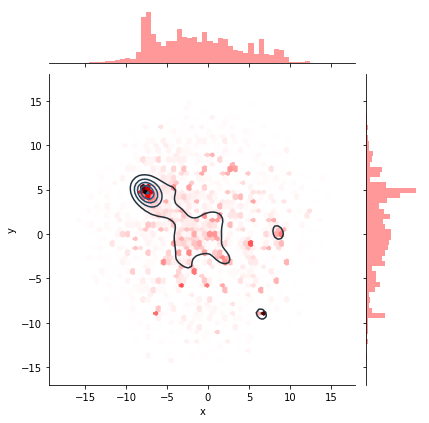

In [1027]:
# Create positive prediction kernel density plot
sns_plot = sns.jointplot(
    viz_df[viz_df['y_pred_pred']==1]['y_pred_xcord'],
    viz_df[viz_df['y_pred_pred']==1]['y_pred_ycord'],
    kind="hex",
    color="red").plot_joint(sns.kdeplot, zorder=1, n_levels=5).set_axis_labels("x", "y")
sns_plot.savefig("Figures/MultiRel_metapath2vec_orig_UMAP_cac_t_pred_hex_sw{}.png".format(datetime.today().strftime('%Y_%m_%d')))

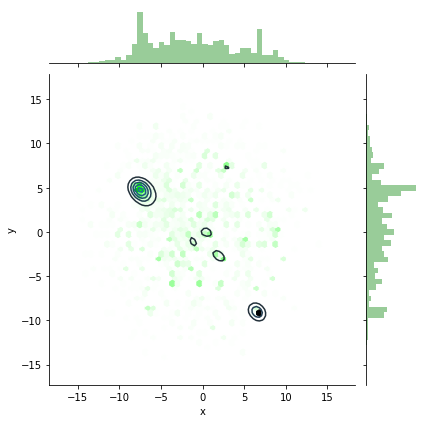

In [1022]:
# Create negative prediction kernel density plot
sns_plot = sns.jointplot(
    viz_df[viz_df['y_pred_pred']==0]['y_pred_xcord'],
    viz_df[viz_df['y_pred_pred']==0]['y_pred_ycord'],
    kind="hex",
    color="green").plot_joint(sns.kdeplot, zorder=1, n_levels=5).set_axis_labels("x", "y")
sns_plot.savefig("Figures/MultiRel_metapath2vec_orig_UMAP_cac_t_pred_hex_nosw{}.png".format(datetime.today().strftime('%Y_%m_%d')))

# Doc2Vec Analyses

## DBOW model evaluation

In [6]:
# Print the 20 most similar dbow doctags to SuicideWatch
model_dbow.docvecs.most_similar(positive=['SuicideWatch'], topn=20)

[('depression', 0.9595265984535217),
 ('MMFB', 0.9271743297576904),
 ('depression_help', 0.9236374497413635),
 ('whatsbotheringyou', 0.9202948212623596),
 ('depressed', 0.9156358242034912),
 ('Suicide_help', 0.9130778312683105),
 ('sad', 0.9110236763954163),
 ('suicidenotes', 0.9109750986099243),
 ('offmychest', 0.9064748883247375),
 ('SanctionedSuicide', 0.9048740267753601),
 ('getting_over_it', 0.9028440713882446),
 ('venting', 0.8982775807380676),
 ('mentalhealth', 0.8886355757713318),
 ('selfhelp', 0.8877691626548767),
 ('Vent', 0.8870785236358643),
 ('MomForAMinute', 0.8847565054893494),
 ('helpmecope', 0.8794957995414734),
 ('mentalillness', 0.876664936542511),
 ('MyLittleSupportGroup', 0.8710669875144958),
 ('needadvice', 0.8694227337837219)]

### DM model evaluation

In [32]:
# Print the 20 most similar dmm doctags to SuicideWatch
model_dmm.docvecs.most_similar(positive=['SuicideWatch'], topn=20)

[('depression', 0.9886905550956726),
 ('depressed', 0.9801347255706787),
 ('depression_help', 0.9759532809257507),
 ('Suicide_help', 0.9659072756767273),
 ('getting_over_it', 0.9646139144897461),
 ('Prevent_Suicide', 0.9627123475074768),
 ('mentalhealth', 0.9618516564369202),
 ('sad', 0.9572824835777283),
 ('MMFB', 0.9571409225463867),
 ('SanctionedSuicide', 0.949762225151062),
 ('venting', 0.9487173557281494),
 ('suicidenotes', 0.9485184550285339),
 ('mentalillness', 0.945374608039856),
 ('ptsd', 0.9435155987739563),
 ('BPD', 0.9409050941467285),
 ('MyLittleSupportGroup', 0.9379068613052368),
 ('suicidalthoughts', 0.935742974281311),
 ('selfhelp', 0.9357046484947205),
 ('whatsbotheringyou', 0.9351156949996948),
 ('MomForAMinute', 0.9350012540817261)]

########################################################################################
########################################################################################

# Evaluate the correlation between MP2V and D2V similarities

In [ ]:
# Reload text data
path_text = "/media/seagate0/reddit/samples/sample_main_50elsm_data_prep_dist.csv"
data_text = pd.read_csv(path_text)
data_text.dropna(inplace=True)
#data_text["text_prep"] = data_text["text_prep"].apply(lambda x: x.split())
print(data_text.shape)
data_text.head()

In [ ]:
# Get authors
authors_list = set(data_text["submission_author"].values)
print("authors_list len:", len(authors_list))
list(authors_list)[:10]

In [16]:
# Get subreddits
subr_list = set(data_text["subreddit"].values)
print("subr_list len:", len(subr_list))
list(subr_list)[:10]

subr_list len: 18091


['runningmusic',
 'illuminati',
 'ninjawarrior',
 'morebreedingdittos',
 'granturismo',
 'keyshare',
 'discordian',
 'EnVyCoD',
 'moviescirclejerk',
 'debates']

In [ ]:
# Get Boolean for whether author every posted in SW
SW_authors = data_text[data_text["subreddit"] == "SuicideWatch"]
SW_authors = set(SW_authors["submission_author"].values)
print("SW_authors len:", len(SW_authors))
list(SW_authors)[:10]

authors_y = {}
for author in set(data_text["submission_author"].values):
    if author in SW_authors:
        authors_y[author] = 1
    else:
        authors_y[author] = 0
print("authors_y len:", len(authors_y.keys()))
print("SW authors in authors_y:", sum(authors_y.values()))
list(authors_y.items())[:10]

In [18]:
%%time
# Plot the transformed embeddings
node_colours_mp2v_t = []
node_markers_mp2v_t = []
node_names_mp2v_t   = []
node_targets_mp2v_t = []
y_name = []
y = []
X = []

# Color and annotate node by type and community
for i in range(len(node_ids_mp2v)):
    # Skip first entity (</s> token) in node_ids_mp2v
    if i == 0:
        continue
    # Convert appended name (eg, v_* ) to real name and get UMAP pos
    node_id   = names_ids[node_ids_mp2v[i]]
    node_name = node_ids_mp2v[i][2:]
    # Get node information if node in author or subreddit list
    if node_name in authors_list or node_name in subr_list:
        if graph.vp.type[node_id] == "subreddit":
            node_targets_mp2v_t.append(graph.vp.type[node_id])
            if graph.vp.MH_subreddits[node_id] == True:
                if node_name == "SuicideWatch":
                    node_markers_mp2v_t.append("P")
                    node_colours_mp2v_t.append([255/255,0.,0.,1])
                    node_names_mp2v_t.append(node_name)
                else:
                    node_markers_mp2v_t.append("^")
                    node_colours_mp2v_t.append([0.,0.,255/255,.5])
                    if random.random() < 1.1:
                        node_names_mp2v_t.append(node_name)
                    else:
                        node_names_mp2v_t.append('')
            elif graph.vp.SH_subreddits[node_id] == True:
                node_markers_mp2v_t.append("^")
                node_colours_mp2v_t.append([100/255,0.,255/255,.4])
                node_names_mp2v_t.append(node_name)
            else: #random subreddits
                node_markers_mp2v_t.append("^")
                node_colours_mp2v_t.append([0.,255/255,0.,.3])
                if random.random() < 0.01:
                    node_names_mp2v_t.append(node_name)
                else:
                    node_names_mp2v_t.append('')
        elif graph.vp.type[node_id] == "author":
            try:
                if authors_y[node_name] == 1:
                    if random.random() < 0.05:
                        node_names_mp2v_t.append("swauth")
                    else:
                        node_names_mp2v_t.append('')
                else:
                    node_names_mp2v_t.append('')
                y_name.append(node_name)
                y.append(authors_y[node_name])
                X.append(node_embeddings_mp2v[i])
            except:
                node_names_mp2v_t.append('')
                pass
            node_markers_mp2v_t.append(".")
            node_colours_mp2v_t.append([255/255,155/255,0.,.035])
            node_targets_mp2v_t.append(graph.vp.type[node_id])
        else: #submissions/comments (should be excluded from cac sample)
            raise ValueError("Unexpected value at node_ids_mp2v index", i)
            
print("node_names_mp2v_t len:", len(node_names_mp2v_t), "\n")
for i in list(zip(node_targets_mp2v_t[:20], node_colours_mp2v_t[:20])): print (i)
    
print("\nY[0] ({}) = {}\nX[0] = {}".format(y_name[0],y[0],X[0]))

node_names_mp2v_t len: 305097 

('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('author', [1.0, 0.6078431372549019, 0.0, 0.035])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('author', [1.0, 0.6078431372549019, 0.0, 0.035])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])

Y[0] (reddit) = 0
X[0] = [ 0.1110605  -0.47061664  0.35729128  0.1100992  -0.51022977  0.06317323
  0.06556737 -0.01871168  0.16747268  0.74743223 -0.25490806  0.5950831
  0.6613076  -0.4976325  -0.15239035 -0.4378079  

In [23]:
# Get authors' d2v distance to SW
swdist_dbow_mean_temp = {}
swdist_dmm_mean_temp  = {}

swdist_authors = data_text.groupby("submission_author").groups.keys()

swdist_dbow_mean_list = data_text.groupby("submission_author")["sw_dist"].mean()
swdist_dbow_mean_list = list(zip(swdist_authors, swdist_dbow_mean_list))
swdist_dbow_mean_temp = {auth:dist for (auth,dist) in swdist_dbow_mean_list}
print("swdist_dbow_mean_temp len:", len(swdist_dbow_mean_temp))

swdist_dmm_mean_list = data_text.groupby("submission_author")["sw_dist_dmm"].mean()
swdist_dmm_mean_list = list(zip(swdist_authors, swdist_dmm_mean_list))
swdist_dmm_mean_temp = {auth:dist for (auth,dist) in swdist_dmm_mean_list}
print("swdist_dmm_mean_temp len:", len(swdist_dmm_mean_temp))

swdist_dbow_mean_temp len: 689500
swdist_dmm_mean_temp len: 689500


In [24]:
# Get authors' mp2v distance to SW
swdist_mp2v = {}
swdist_dbow_mean = {}
swdist_dmm_mean  = {}
swdist_d2v_mean = {}

for i,name in enumerate(y_name):
    swdist = model_mp2v.similarity("v_SuicideWatch", "a_"+name)
    swdist_mp2v[name] = swdist
    swdist_dbow_mean[name] = swdist_dbow_mean_temp[name]
    swdist_dmm_mean[name]  = swdist_dmm_mean_temp[name]
    swdist_d2v_mean[name] = (swdist_dbow_mean[name] + swdist_dmm_mean[name])/2
    
print("swdist_mp2v len:", len(swdist_mp2v))
print("swdist_dbow_mean len:", len(swdist_dbow_mean))
print("swdist_dmm_mean len:", len(swdist_dmm_mean))
print("swdist_d2v_mean len:", len(swdist_d2v_mean))

swdist_mp2v len: 293503
swdist_dbow_mean len: 293503
swdist_dmm_mean len: 293503
swdist_d2v_mean len: 293503


In [25]:
# Create dataframe of distances
dist_df = pd.DataFrame(list(swdist_mp2v.values()))
del dist_df[0]
dist_df["mp2v"] = pd.DataFrame(list(swdist_mp2v.values()))
dist_df["dbow"] = pd.DataFrame(list(swdist_dbow_mean.values()))
dist_df["dmm"] = pd.DataFrame(list(swdist_dmm_mean.values()))
dist_df["d2v_mean"] = pd.DataFrame(list(swdist_d2v_mean.values()))
print("dist_df shape:", dist_df.shape)
dist_df.head()

dist_df shape: (293503, 4)


,mp2v,dbow,dmm,d2v_mean
0,0.265112,0.286392,0.381673,0.334033
1,0.204839,0.208094,0.406032,0.307063
2,0.200469,0.196550,0.428563,0.312556
3,0.225010,0.234255,0.333922,0.284089
4,0.232969,0.256413,0.371321,0.313867


In [26]:
# Correlate distances
dist_df.corr(method="pearson")

,mp2v,dbow,dmm,d2v_mean
mp2v,1.000000,0.229017,0.154803,0.223434
dbow,0.229017,1.000000,0.586228,0.936908
dmm,0.154803,0.586228,1.000000,0.832450
d2v_mean,0.223434,0.936908,0.832450,1.000000


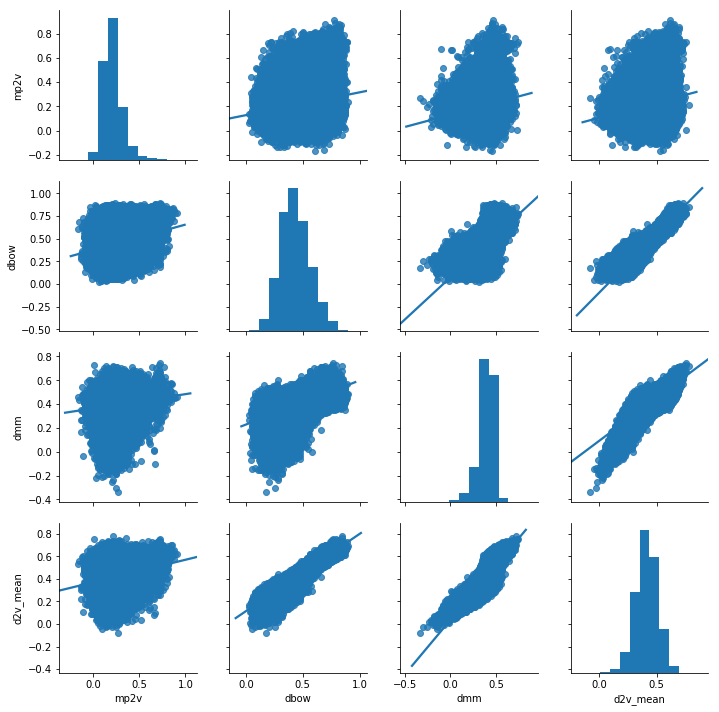

In [28]:
# plot correlation
sns_plot = sns.pairplot(dist_df, kind="reg")
sns_plot.savefig("Figures/mp2v_d2v_corrs_{}.png".format(datetime.today().strftime('%Y_%m_%d')))

############################################################
############################################################

# metapath2vec 3D visualizations

## Get 3D embedding positions

In [12]:
%%time
# Run UMAP transformation
print("Start time:", datetime.now())
time_start = time()
embeddings_3d_mp2v = umap.UMAP(n_components=3,
                               n_neighbors=50,
                               min_dist=0.1,
                               metric='cosine',
                               angular_rp_forest=True,
                               random_state=407,
                               verbose=True).fit_transform(node_embeddings_mp2v)
print("embeddings_3d_mp2v shape:", embeddings_3d_mp2v.shape)
print("End time:", datetime.now(), "\n")

Start time: 2019-05-11 11:11:00.581591
UMAP(a=None, angular_rp_forest=True, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='cosine',
   metric_kwds=None, min_dist=0.1, n_components=3, n_epochs=None,
   n_neighbors=50, negative_sample_rate=5, random_state=407,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  21
	 1  /  21
	 2  /  21
	 3  /  21
	 4  /  21
	 5  /  21
	 6  /  21
	 7  /  21
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
embeddings_3d_mp2v shape: (1831614, 3)
En

In [13]:
%%time
# Plot the transformed embeddings
node_colours_mp2v = []
node_markers_mp2v = []
node_names_mp2v   = []
node_targets_mp2v = []
node_zorder       = []
node_size         = []
node_x_embeddings_mp2v = []
node_y_embeddings_mp2v = []
node_z_embeddings_mp2v = []

# Color and annotate node by type and community
for i in range(len(node_ids_mp2v)):
    # Skip first entity (</s> token) in node_ids_mp2v
    if i == 0:
        continue
    # Convert appended name (eg, v_* ) to real name and get UMAP pos
    node_id   = names_ids[node_ids_mp2v[i]]
    node_name = node_ids_mp2v[i][2:]
    node_targets_mp2v.append(graph.vp.type[node_id])
    node_x_embeddings_mp2v.append(embeddings_3d_mp2v[:,0][i])
    node_y_embeddings_mp2v.append(embeddings_3d_mp2v[:,1][i])
    node_z_embeddings_mp2v.append(embeddings_3d_mp2v[:,2][i])
    if graph.vp.type[node_id] == "subreddit":
        if graph.vp.MH_subreddits[node_id] == True:
            if node_name == "SuicideWatch":
                node_markers_mp2v.append("P")
                node_colours_mp2v.append([255/255,0.,0.,1])
                node_names_mp2v.append(node_name)
                node_zorder.append(99*99)
                node_size.append(10)
            else:
                node_markers_mp2v.append("^")
                node_colours_mp2v.append([0.,0.,255/255,.5])
                node_zorder.append(99*9)
                node_size.append(5)
                if random.random() < 1.1:
                    node_names_mp2v.append(node_name)
                else:
                    node_names_mp2v.append('')
        elif graph.vp.SH_subreddits[node_id] == True:
            node_markers_mp2v.append("^")
            node_colours_mp2v.append([100/255,0.,255/255,.4])
            node_names_mp2v.append(node_name)
            node_zorder.append(99)
            node_size.append(5)
        else: #random subreddits
            node_markers_mp2v.append("^")
            node_colours_mp2v.append([0.,255/255,0.,.3])
            node_zorder.append(2)
            node_size.append(2)
            if random.random() < 0.01:
                node_names_mp2v.append(node_name)
            else:
                node_names_mp2v.append('')
    elif graph.vp.type[node_id] == "author":
        node_markers_mp2v.append(".")
        node_colours_mp2v.append([255/255,155/255,0.,.035])
        node_names_mp2v.append('')
        node_zorder.append(1)
        node_size.append(1)
    else: #submissions/comments (should be excluded from cac sample)
        raise ValueError("Unexpected value at node_ids_mp2v index", i)
for i in list(zip(node_targets_mp2v[:20], node_colours_mp2v[:20])): print (i)

('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('author', [1.0, 0.6078431372549019, 0.0, 0.035])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('author', [1.0, 0.6078431372549019, 0.0, 0.035])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('author', [1.0, 0.6078431372549019, 0.0, 0.035])
('author', [1.0, 0.6078431372549019, 0.0, 0.035])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
('subreddit', [0.0, 1.0, 0.0, 0.3])
CPU times: user 5min 21s, sys: 944 ms, total: 5min 22s
Wall time: 5min 22s


## Plot static 3D visualization

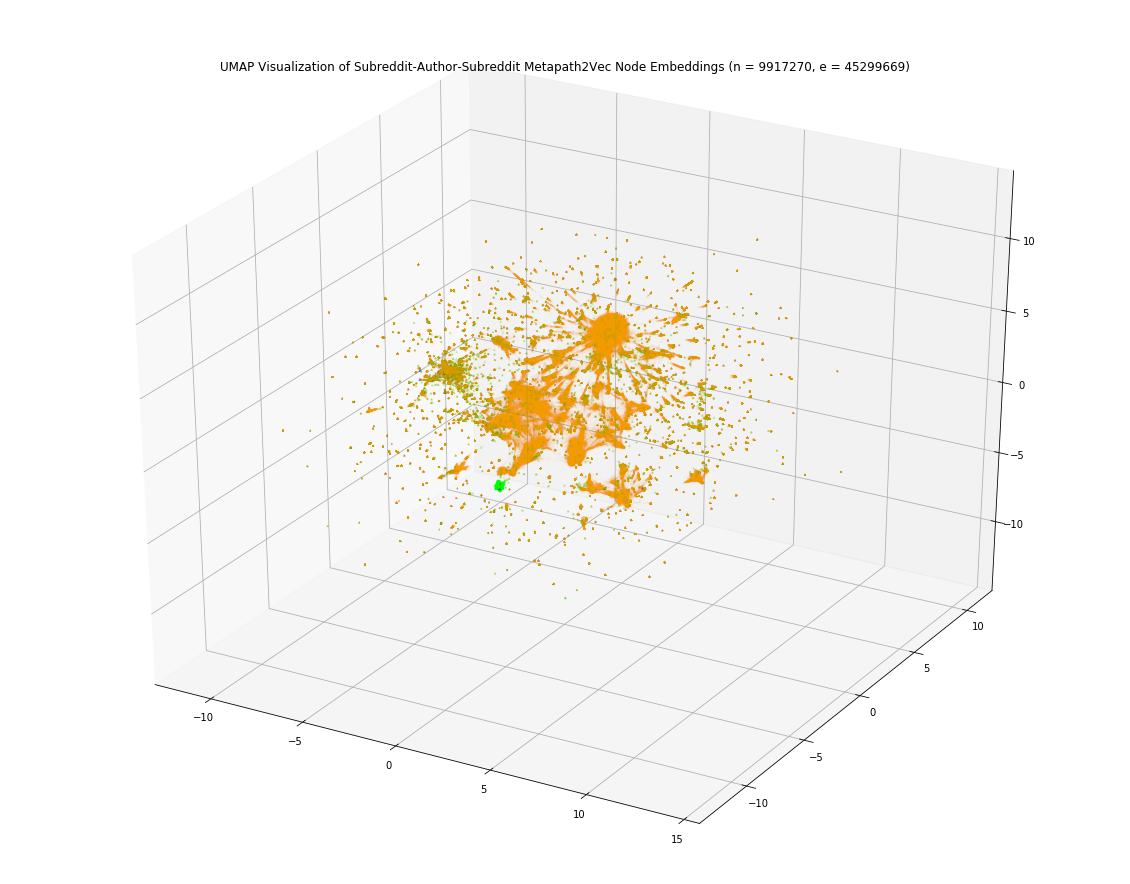

In [14]:
# Plot static 3D visualization of embeddings
fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    embeddings_3d_mp2v[1:,0],
    embeddings_3d_mp2v[1:,1],
    embeddings_3d_mp2v[1:,2],
    c=node_colours_mp2v,
    marker="^",
    s=node_size,
    zorder=node_zorder)

plt.title('UMAP Visualization of Subreddit-Author-Subreddit Metapath2Vec Node Embeddings (n = {}, e = {})'.format(
    graph.num_vertices(),
    graph.num_edges()))

'''
for i,txt in enumerate(node_names_mp2v):
    if txt in MH_subreddits:
        if txt == "SuicideWatch":
            plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.0,size=1)[0]),
                     node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.0,size=1)[0]),
                     node_z_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.0,size=1)[0]),
                     txt,
                     fontweight='bold',
                     fontsize=16,
                     s=5,
                     color=[255/255,0.,0.,1],
                     zorder=8,
                     bbox=dict(facecolor='none', edgecolor='red', boxstyle='round'))
        elif txt == "depression":
            plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_z_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     s=5,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=7,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "Anxiety":
            plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_z_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     s=5,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=7,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "mentalhealth":
            plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_z_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     s=5,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=7,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "OCD":
            plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_z_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     s=5,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=7,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "ptsd":
            plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_z_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     s=5,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=7,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "BPD":
            plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_z_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     s=5,
                     fontsize=12,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=7,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "schizophrenia":
            plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_z_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     s=5,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=7,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "Anger":
            plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_z_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     s=5,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=7,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        elif txt == "addiction":
            plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_z_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     s=5,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=7,
                     bbox=dict(facecolor='none', edgecolor='blue', boxstyle='round'))
        else:
            plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     node_z_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                     txt,
                     fontsize=12,
                     s=5,
                     color=[0.,0.,255/255,.7],
                     alpha=.7,
                     zorder=7)
    elif txt in SH_subreddits:
        plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                 node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                 node_z_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                 txt,
                 fontsize=12,
                 s=5,
                 color=[100/255,0.,255/255,.7],
                 alpha=.7,
                 zorder=6)
    else:
        plt.text(node_x_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                 node_y_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                 node_z_embeddings_mp2v[i]*(np.random.uniform(low=1.0,high=1.4,size=1)[0]),
                 txt,
                 fontsize=10,
                 s=5,
                 alpha=.25,
                 zorder=5)
'''
        
plt.savefig('Figures/MultiRel_metapath2vec_orig_UMAP_cac_3D_{}.png'.format(datetime.today().strftime('%Y_%m_%d')))
plt.show()

In [16]:
plt.close()

## Plot rotating 3D animation

In [ ]:
# Make 3D rotating animation(python-graph-gallery.com/342-animation-on-3d-plot/)
# We are going to do 20 plots, for 20 different angles
for angle in range(70,210,2):

    # Make the plot
#    fig = plt.figure(figsize=(20,16))
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.scatter(
        embeddings_3d_mp2v[1:,0],
        embeddings_3d_mp2v[1:,1],
        embeddings_3d_mp2v[1:,2],
        c=node_colours_mp2v,
        marker="^",
        s=node_size,
        zorder=node_zorder)

    # Set the angle of the camera
    ax.view_init(30,angle)

    # Save it
    filename='Figures/animate/metapath2vec_cac_step'+str(angle)+'.png'
    plt.savefig(filename, dpi=96)
    plt.gca()

# Then use image magick to transform all the png files into an GIF file
# Run these in bash, not python:
    # cd Figures/animate/
    # convert -delay 50 metapath2vec_cac*.png animated_metapath2vec_cac.gif

In [19]:
plt.close()